In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sklearn
import separator

sep = separator.SeparateText()

# print versions of libraries
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"sklearn version: {sklearn.__version__}")

numpy version: 1.26.3
pandas version: 2.2.0
sklearn version: 1.4.0


In [2]:
# import mnist dataset
# Sklearn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# The dict keys you see above can be used for various purposes. For example, in the row below you see that you can use "data" and "target" to access features and labels of the dataset.
X, y = np.array(mnist["data"]), np.array(mnist["target"])

print("Shape of all features: ", X.shape)
print(f"Each feature is an image 28x28: {28**2=}")  # number of pixels each image has (28x28)
print("Contents of first index of features: ", X[0])
print("Shape of labels: ", y.shape)
print("Content of first index of labels: ", y[0])  # first number is labeled as 5

Shape of all features:  (70000, 784)
Each feature is an image 28x28: 28**2=784
Contents of first index of features:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  5

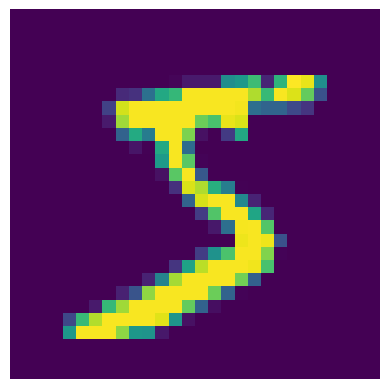

In [4]:
# Take first element of the features
some_digit = np.array(X)[0]

# Reshape the first element from 1D array to 2D array
some_digit_image = some_digit.reshape(28, 28)

# Plot the image
plt.imshow(some_digit_image)
plt.axis("off")
plt.show()

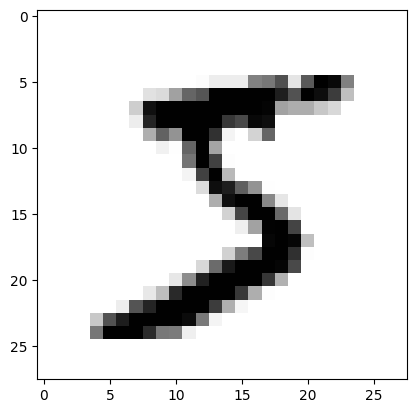

In [5]:
# Convert to black and white colors.
plt.imshow(some_digit_image, cmap="binary")
plt.show()

In [6]:
# Check label of the first image. It is number 5 just as we see on the image.
y[0]

'5'

In [7]:
# Labels are stored as strings in this dataset so let's change them to int.
print(type(y[0]))

# Convert to int
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


In [8]:
# Custom function of author of the book to plot multiple images in a grid. If you are interested you can check out the source code below, otherwise it is not important to understand it to continue in this notebook.
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

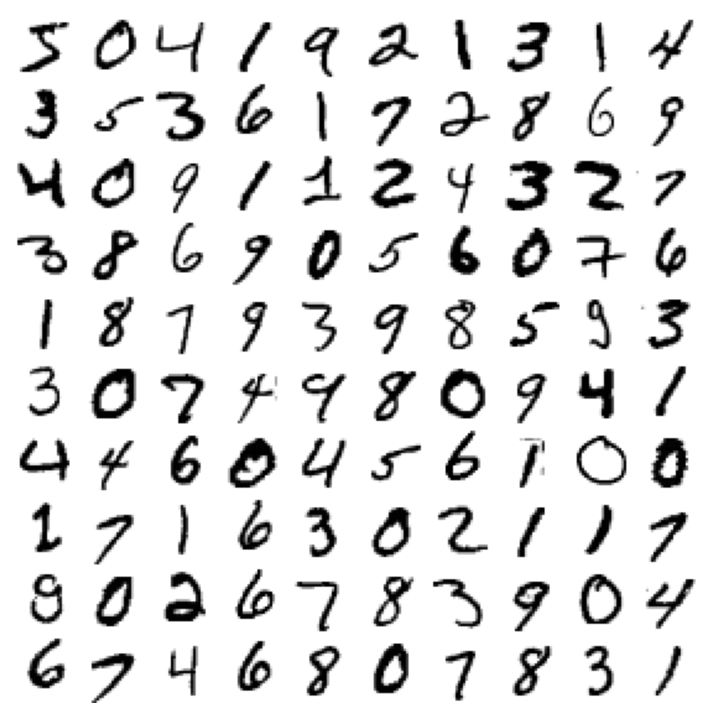

In [9]:
# Display a bunch of images in a grid.
plt.figure(figsize=(9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [10]:
# Mnist dataset is already shuffled (cross-validation folds will be similar) and already split into training and test set (first 60,000 are training, remaining 10,000 are test set). 

X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

# BINARY CLASSIFIER


In [11]:
# Let's train a classifier to only predict whether number is 5 or not in this dataset. Meaning we will have only two classes: 5 and not 5.

# This numpy syntax applies to each item in array. It will return True for all 5s, and False for all other digits.
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [12]:
# See that the places where we have 5 is True, and where we don't have 5 is False.
print(y_train_5)
print(y_train)

[ True False False ...  True False False]
[5 0 4 ... 5 6 8]


In [13]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

# PERFORMANCE MEASURES

#### CROSS-VALIDATION

In [14]:
# Build custom cross validation (can be useful if you want more control over it)
# Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. In these cases, you can implement cross-validation yourself. The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and prints the same result:

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# StratifiedKFold - This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
# In my own words, you can get out of this object with these parameters 3 splits. And each spilt will have 2 arrays. First array will be the indexes of the training set, and second array will be the indexes of the test set. The indexes are shuffled and stratified (meaning that each split will have same percentage of each class as the whole dataset).
number_of_splits = 3
stratified_k_folds = StratifiedKFold(
    n_splits=number_of_splits,
    shuffle=True,
    random_state=42,
)

#------------------------------------------------------------------------------------------------
# Just my own extra data to explain stuff:
print(
    "Visualisation of stratified k folds. These are only indexes which you will later use as a filter to get actual data from dataset:\n")
for train, test in stratified_k_folds.split(X_train, y_train_5):
    # In the printed data you will see that the number of data is still 60_000, but the length of train and test set will be the result of 60_000 / n_splits. In this case of 3 splits 40 vs 20 thousand.
    print(train, f"Shape: {train.shape}")
    print(test, f"Shape: {test.shape}")
    print("-" * 50)

#------------------------------------------------------------------------------------------------

print("\nActual custom implementation of cross validation:\n")
scores = []
for train_index, test_index in stratified_k_folds.split(X_train, y_train_5):
    # Clone the classifier to have the exact same model as before. Author of the book does not explain why.
    clone_classifier = clone(sgd_classifier)

    # Get the actual training and test set values from the dataset using the indexes from the stratified k folds.
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # Train the model, predict and compute accuracy.
    clone_classifier.fit(X_train_folds, y_train_folds)
    y_pred = clone_classifier.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    result = n_correct / len(y_pred)
    scores.append(result)
    print(f"Accuracy: {result}")

print(f"Mean of all accuracy {number_of_splits} scores: {np.array(scores).mean()}")

# Still remember that the results you see here, are made on classification whether number is 5 or not.

Visualisation of stratified k folds. These are only indexes which you will later use as a filter to get actual data from dataset:

[    1     3     4 ... 59994 59996 59998] Shape: (40000,)
[    0     2     6 ... 59995 59997 59999] Shape: (20000,)
--------------------------------------------------
[    0     2     3 ... 59997 59998 59999] Shape: (40000,)
[    1    10    11 ... 59988 59989 59991] Shape: (20000,)
--------------------------------------------------
[    0     1     2 ... 59995 59997 59999] Shape: (40000,)
[    3     4     5 ... 59994 59996 59998] Shape: (20000,)
--------------------------------------------------

Actual custom implementation of cross validation:

Accuracy: 0.9669
Accuracy: 0.91625
Accuracy: 0.96785
Mean of all accuracy 3 scores: 0.9503333333333334


In [15]:
# we can use the build-in function to do the same cross-validation as above
from sklearn.model_selection import cross_val_score

results = cross_val_score(
    estimator=sgd_classifier,
    X=X_train,
    y=y_train_5,
    verbose=2,
    cv=3,
    scoring="accuracy",
)
results

[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   5.0s


array([0.95035, 0.96035, 0.9604 ])

In [16]:
f"Accuracy from build-in sklearn function: {results.mean()}"

'Accuracy from build-in sklearn function: 0.9570333333333334'

In [17]:
# Let's pretend that we create a custom estimator that always predicts that the number is not 5, to see that accuracy is not always the best metric to use.

from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        # Create a matrix of shape X, 1. Complete array with False values.
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
np.zeros((len(X), 1), dtype=bool)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [19]:
# Our custom estimator will always predict that the number is not 5. But since we have 10 numbers, it will be right 90% of the time. So accuracy is not always the best metric to use.
never_5_clf = Never5Classifier()
print("Accuracy scores: ",
      cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

Accuracy scores:  [0.91125 0.90855 0.90915]


#### CONFUSION MATRIX
If you are interested, there is also dedicated notebook for confusion matrix in this repository.

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.
# To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:
y_train_predictions = cross_val_predict(
    estimator=sgd_classifier,
    X=X_train,
    y=y_train_5,
    cv=3
)
# Just like cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).
# Little more explanation of cross_val_predict() function by github-copilot:
# Question by TL: Lets say you have linear regression model, and you are trying to predict a number. You have 1000 train features. You tell the method to use 3 fold split. Does it mean that when the cross_val_predict is executed, the resulting prediction is an average of 3 numbers or not?
# Answered by copilot: No, the resulting prediction from cross_val_predict is not an average of 3 numbers. When you specify a 3-fold cross-validation, the function splits the training data into 3 subsets. Then, it trains the model on 2 of these subsets and makes predictions on the remaining subset. This process is repeated 3 times, with each subset used exactly once as the validation data. The function then returns the predictions made on each subset. So, for each feature in your dataset, you get a prediction that was made when that feature was in the validation set.

# Check how the classifier was able to predict whether the number is 5 or not.
confusion_matrix(y_train_5, y_train_predictions)
# below you can see printed confusion matrix:
# [[True negatives, False positives]
#  [False negatives, True positives]]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# calculate precision
# meaning: How many times are you correct when you say that the number is 5?
print(f"Precision: {precision_score(y_train_5, y_train_predictions)}")

# calculate recall
# meaning: How many of 5s did you detect?
print(f"Recall: {recall_score(y_train_5, y_train_predictions)}")

# calculate harmonic mean of those above (harmonic mean gives more weight to low values, therefore score is going to be worse than when using normal mean, if you do not have precision and recall numbers close to each other)
print(f"F1 score (harmonic mean): {f1_score(y_train_5, y_train_predictions)}")

# See below, even though our accuracy was high in previous measuring, you see that precision and recall are not that good.

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 score (harmonic mean): 0.7325171197343847


In [22]:
# You can calculate the scores yourself using the confusion matrix array from sklearn.
cm = confusion_matrix(y_train_5, y_train_predictions)

# "cm" is just an array, therefore we access the values using indexes.
print(f"Confusion matrix:\n {cm}\n")
print(f"Precision: {cm[1, 1] / (cm[0, 1] + cm[1, 1])}")
print(f"Recall: {cm[1, 1] / (cm[1, 0] + cm[1, 1])}")
print(f"F1 score: {cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)}")

Confusion matrix:
 [[53892   687]
 [ 1891  3530]]

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 score: 0.7325171197343847


In [23]:
# DECISION FUNCTION (DECISION SCORES)
# The SGDClassifier class uses a decision function to make predictions. The decision function is computed for each instance and a score for each instance is compared to a threshold. If the score is greater than the threshold, the instance is classified as positive, and negative otherwise. The classifier uses default threshold of 0.

# you can see that the sgd_classifier.decision_function returns a score based on which is calculated a prediction
decision_score_of_some_digit = sgd_classifier.decision_function([some_digit])

print("Decision score of 'some_digit': ", decision_score_of_some_digit)

Decision score of 'some_digit':  [2164.22030239]


In [24]:
# below you can see that once the threshold changes, the result of prediction also changes
# Since the 0 is the default threshold value, the code in this cell does the same thing as if you called predict() method.
threshold = 0
y_some_digit_prediction = decision_score_of_some_digit > threshold

# Is the number 5?
y_some_digit_prediction

array([ True])

In [25]:
threshold = 8000
y_some_digit_prediction = decision_score_of_some_digit > threshold

# Is the number 5?
y_some_digit_prediction

array([False])

In [26]:
# with this function you can check decision scores of all 60_000 instances
y_decision_scores = cross_val_predict(
    estimator=sgd_classifier,
    X=X_train,
    y=y_train_5,
    cv=3,
    method="decision_function"  # this will return decision scores instead of predictions
)
y_decision_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

#### PRECISION AND RECALL TRADEOFF

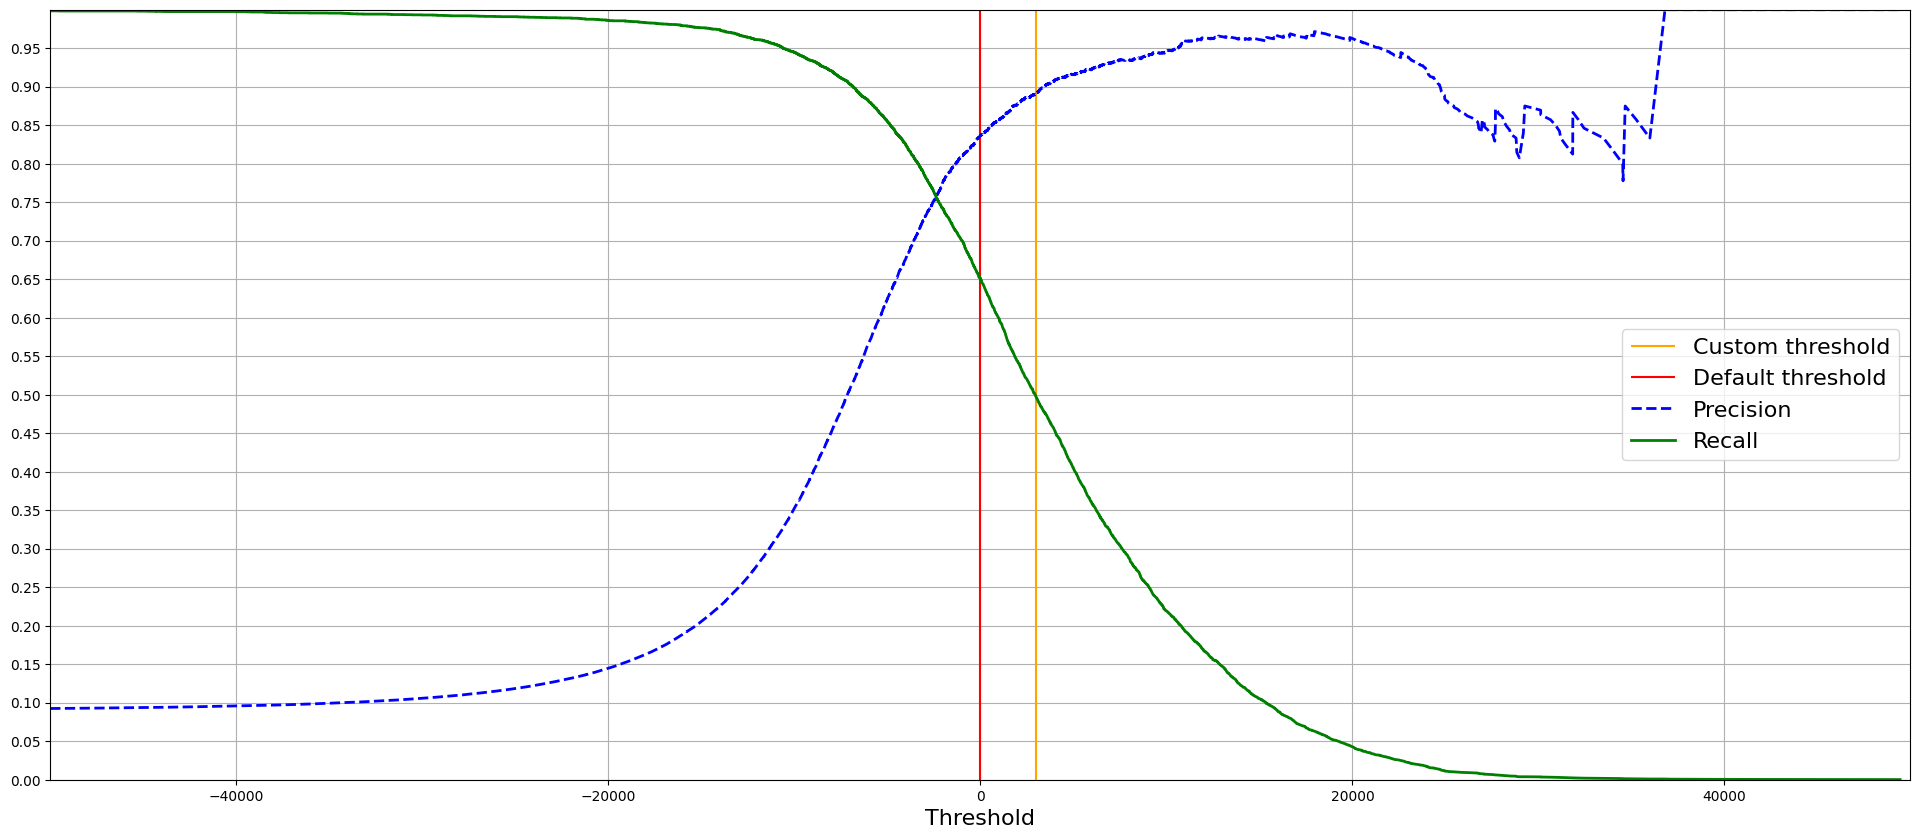

In [30]:
from sklearn.metrics import precision_recall_curve

# You can use sklearn precision_recall_curve() function to compute precision and recall for all possible thresholds. 
# (Applies only to binary classifiers). This might be useful to you if you want to plot precision and recall vs the threshold, in case you want your model to have a specific ratio of precision or recall. With that plot, you can see which threshold you need and then you can your self create a custom filter, which will return predictions based on that custom threshold vs decision scores.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_decision_scores)

custom_threshold = 3000
default_threshold_zero = 0


def plot_precision_recall_vs_threshold(precisions_, recalls_, thresholds_):
    plt.figure(figsize=(24, 10))
    plt.vlines(x=custom_threshold, ymin=0, ymax=1.0, colors="orange", linestyles="solid",
               label="Custom threshold")
    plt.vlines(x=default_threshold_zero, ymin=0, ymax=1.0, colors="red", linestyles="solid",
               label="Default threshold")
    plt.plot(thresholds_, precisions_[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_, recalls_[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.yticks(np.arange(0, 1, step=0.05))
    # plt.xticks(np.arange(-40_000, 40_000, step=5_000))
    plt.axis((-50000, 50000, 0, 1))


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Take a look at the plot below. You see that at default threshold 0, which is used for predictions normally, precision is around 85% and recall around 65%, just as we evaluated it above. (You can check it few cells above)
# In case you wanted for example 90% precision, you can see that you would need to set the threshold to around 3000. But then you would have only around 50% recall. So you can see that there is a tradeoff between precision and recall.

In [31]:
# Just an example how decision scores are evaluated to default threshold of 0.
print(f"Thresholds:\n{thresholds}\n")
print(f"Decision scores:\n{y_decision_scores}\n")
for label, decision_score in zip(y_train[:5], y_decision_scores[:5]):
    print(f"Label: {label}, Prediction: {decision_score > default_threshold_zero}")



Thresholds:
[-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]

Decision scores:
[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]

Label: 5, Prediction: True
Label: 0, Prediction: False
Label: 4, Prediction: False
Label: 1, Prediction: False
Label: 9, Prediction: False


In [33]:
# np.argmax - Returns index position of the highest value you specified in a filter
index_position_for_90_recall = np.argmax(precisions == 0.90)
recall_with_90_precision = recalls[index_position_for_90_recall]
threshold_90_precision = thresholds[index_position_for_90_recall]

# instead of calling default predict() method, we can use our filter with custom threshold which will now evaluate the array to boolean results to get our scoring to desired 90% precision
y_train_90_precision = y_decision_scores >= threshold_90_precision

print(f"Index position for 90 recall: {index_position_for_90_recall}")
print(f"Recall value with 90 precision: {recall_with_90_precision}")
print(f"Threshold value with 90 precision: {threshold_90_precision}")

Index position for 90 recall: 57110
Recall value with 90 precision: 0.47980077476480354
Threshold value with 90 precision: 3370.0692037709423


In [30]:
# results correspond to the plot above and also the one below
print(precision_score(y_train_5, y_train_90_precision))
print(recall_score(y_train_5, y_train_90_precision))

0.9
0.47980077476480354


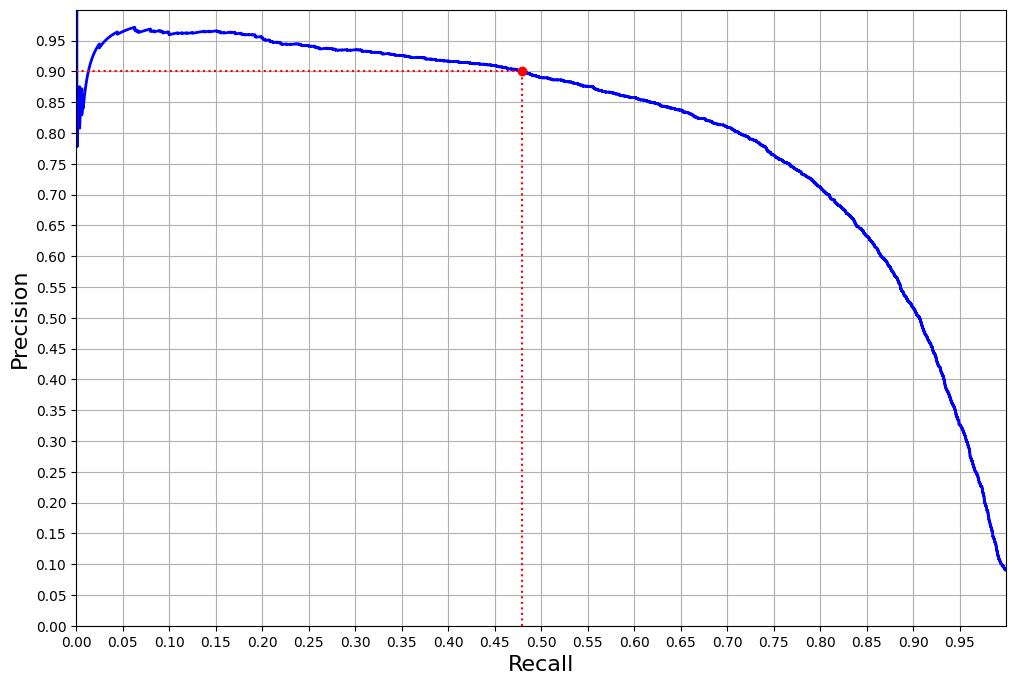

In [31]:
# Plot precision vs recall against each other

def plot_precision_vs_recall(precisions_, recalls_):
    plt.plot(recalls_, precisions_, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis((0, 1, 0, 1))
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, 1, step=0.05))
    plt.grid(True)


plt.figure(figsize=(12, 8))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_with_90_precision, recall_with_90_precision], [0., 0.9], "r:")  # vertical red line
plt.plot([0.0, recall_with_90_precision], [0.9, 0.9], "r:")  # horizontal red line
plt.plot([recall_with_90_precision], [0.9], "ro")  # red dot
plt.show()

# This curve should be close to top right corner in ideal case.

#### ROC CURVE (RECEIVER OPERATING CHARACTERISTICS)

In [32]:
# Another way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC.

# Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use:
#   - Use Precision/Recall curve whenever the positive class is rare 
#   - Use Precision/Recall when you care more about the false positives than the false negatives

# Use the ROC curve otherwise. For example, looking at the ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

from sklearn.metrics import roc_auc_score

# See, the score is high, but it does not make sense to use this metrics, since we have only 10% of 5s in the dataset. Use Precision/Recall curve instead in this case.
print(f"ROC AUC score: {roc_auc_score(y_train_5, y_decision_scores)}")

ROC AUC score: 0.9604938554008616


False positive rate at 90% precision: 0.005295076861063779
Recall at 90% precision: 0.47980077476480354


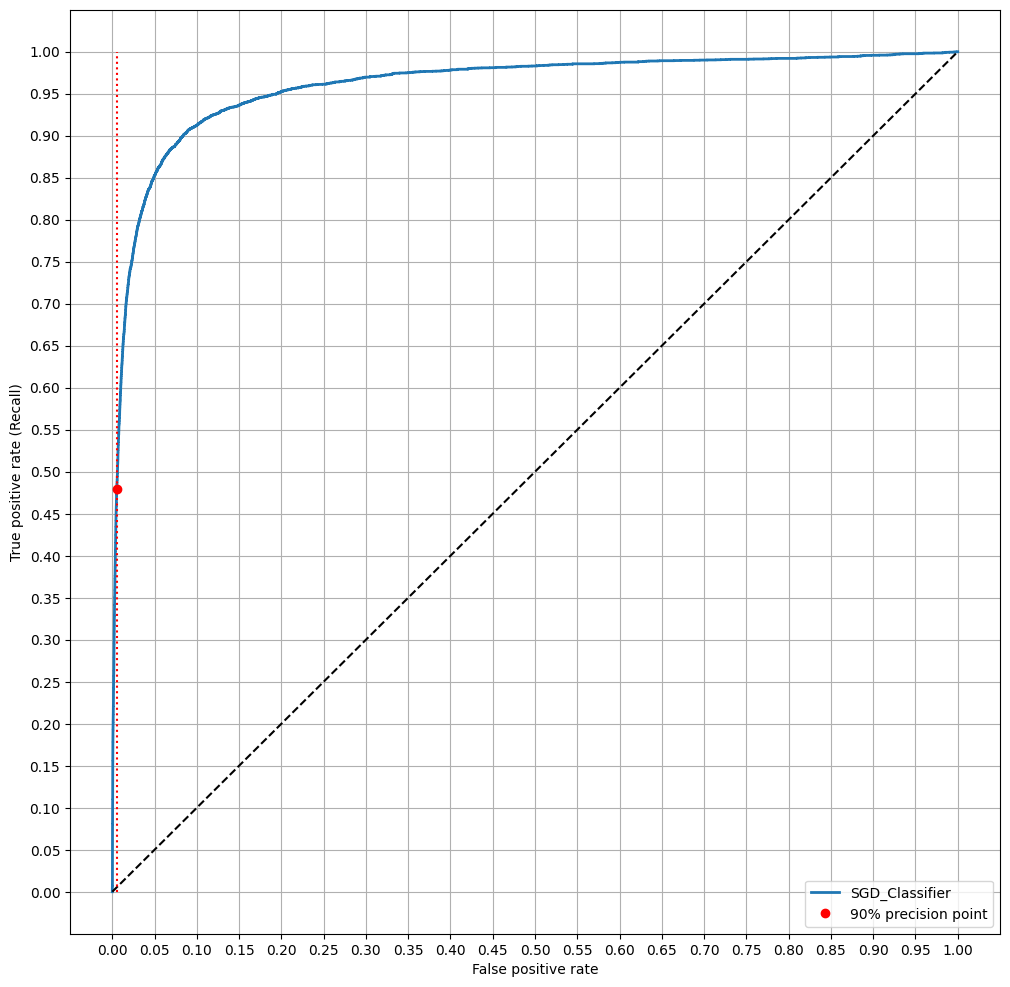

In [33]:
# The plot below shows the ROC curve. This ROC curve plots the false positive rate against the true positive rate (recall) for all possible thresholds, the red circle highlights the chosen ratio (at 47% recall) and the diagonal line is the ROC curve of purely random binary classifier which predicts 50% of each class. Recall is not visible at the graph below, but the ratio of precision and recall is kept the same, therefore the recall you see below still corresponds to  precision of 90%.
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds \
    = roc_curve(y_true=y_train_5, y_score=y_decision_scores)

# Get false positive rate at 90% precision, at 47% recall
false_positive_rate_90 = false_positive_rate[
    np.argmax(true_positive_rate >= recall_with_90_precision)]
print(f"False positive rate at 90% precision: {false_positive_rate_90}")
print(f"Recall at 90% precision: {recall_with_90_precision}")


def plot_roc_curve(fpr, tpr, label_=None):
    """
    :param fpr: false positive rate 
    :param tpr: true positive rate
    :return: 
    """
    plt.plot(fpr, tpr, linewidth=2, label=label_)
    plt.plot([false_positive_rate_90],
             [recall_with_90_precision],
             "ro",
             label="90% precision point")  # red dot
    plt.plot([0, 1], [0, 1], "k--")  # dashed diagonal
    plt.grid()
    plt.yticks(np.arange(0, 1.05, step=0.05))
    plt.xticks(np.arange(0, 1.05, step=0.05))
    plt.plot([false_positive_rate_90, false_positive_rate_90], [0, 1], "r:")  # vertical red line
    plt.ylabel("True positive rate (Recall)")
    plt.xlabel("False positive rate")


plt.figure(figsize=(12, 12))
plot_roc_curve(false_positive_rate, true_positive_rate, "SGD_Classifier")
plt.legend()
plt.show()

# At the plot below, you see that the lower the false positive rate the better for use.
# At the same time the higher the recall the better for us.
# Seems like the ROC plot shows us also that there is some trade-off between false positive rate and recall. The better the false positives, the worse the recall. 
# This means that ideally we want to be as close to the top left corner as possible.

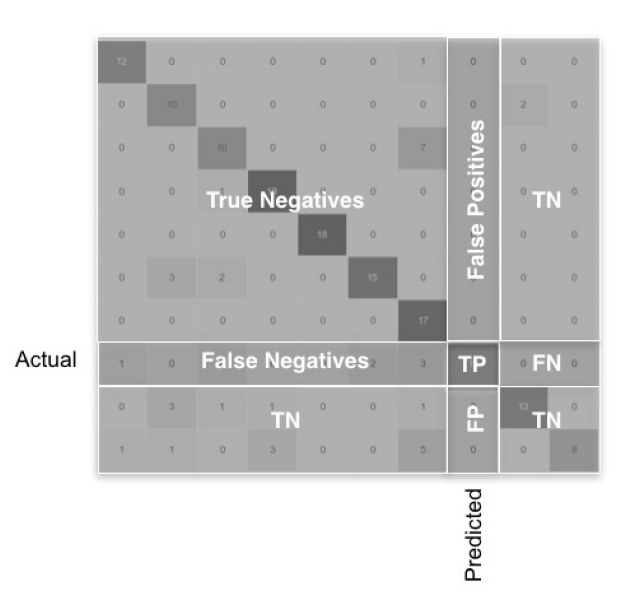

In [34]:
# Just a reminder of the confusion matrix glossary.
plt.figure(figsize=(8, 8))
image = plt.imread(r"..\performace_measurement\images\CONF_MATRIX3.jpg")
plt.axis("off")
plt.imshow(image)

y_train=array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)
y_scores_forest=array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])


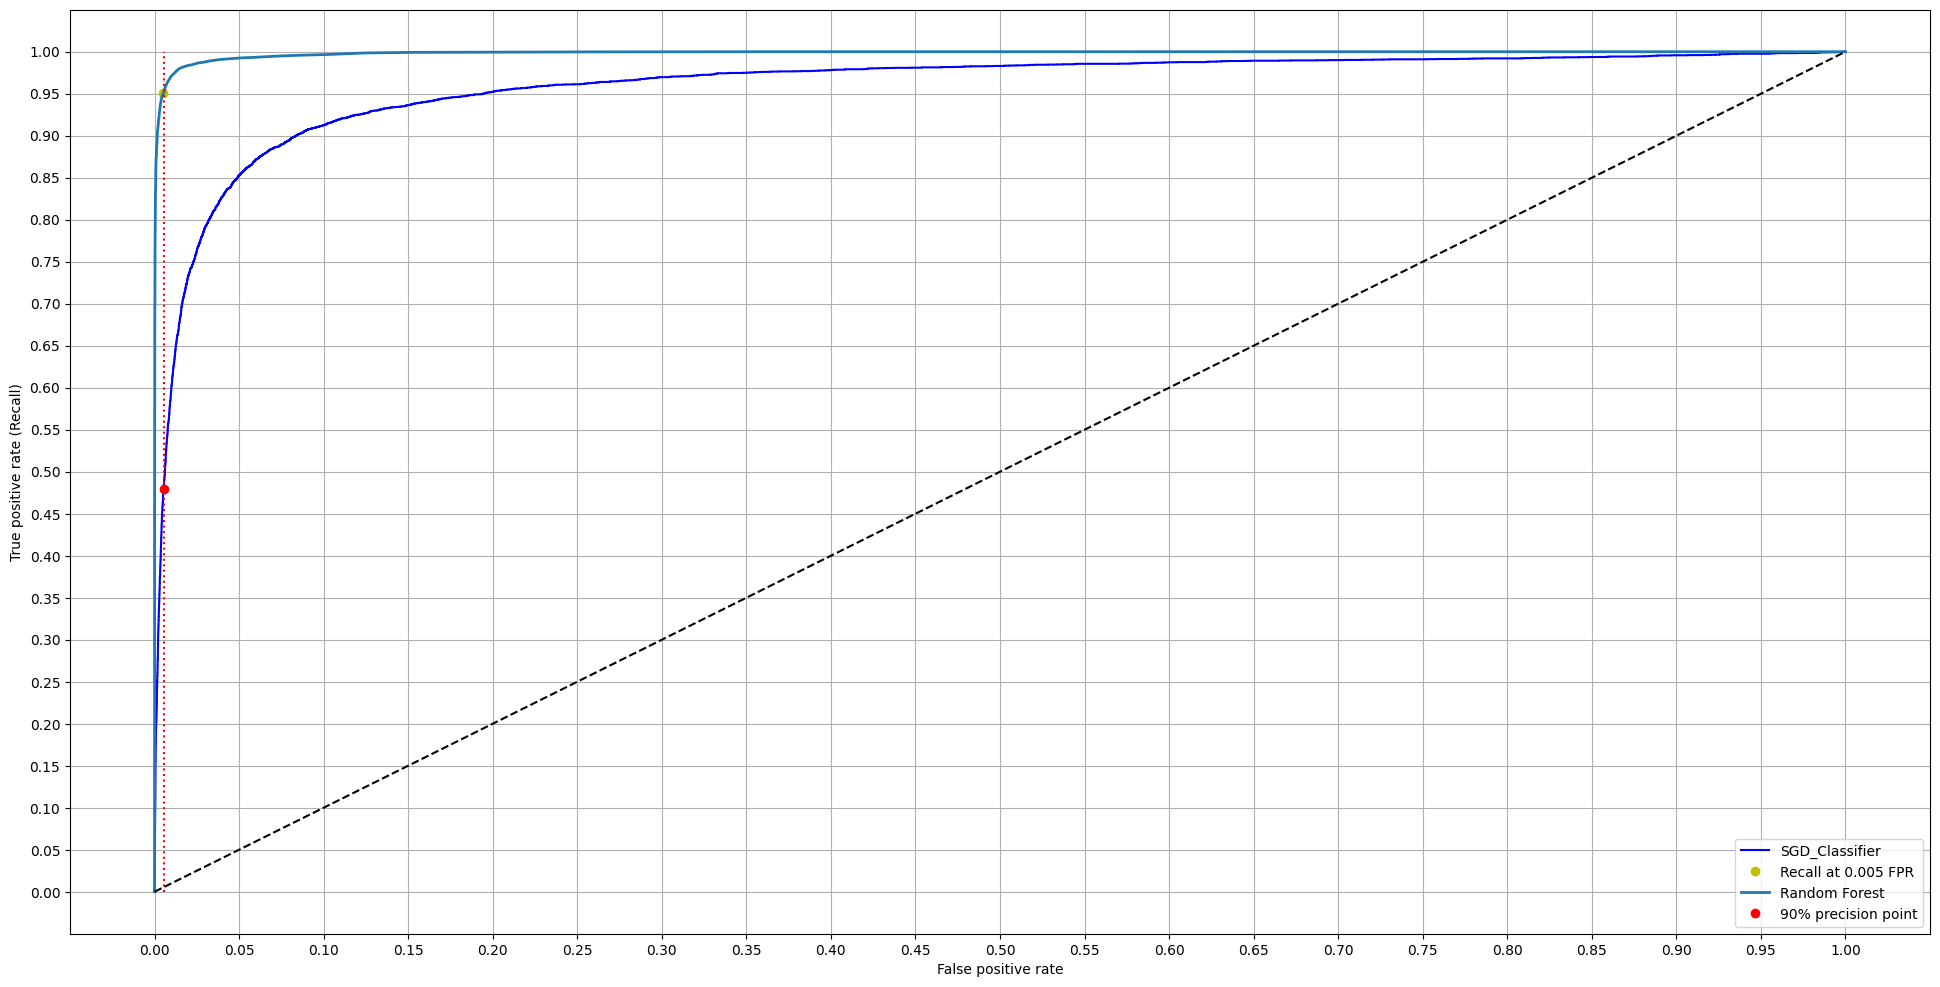

In [35]:
# Compare the roc curve of SGDClassifier vs RandomForestClassifier
# It takes 1 min to run this cell
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probabilities_forest = cross_val_predict(
    estimator=forest_clf,
    X=X_train,
    y=y_train_5,
    cv=3,
    method="predict_proba"
)

y_scores_forest = y_probabilities_forest[:, 1]  # score = probability of positive class
print(f"{y_train=}")
print(f"{y_scores_forest=}")

false_positive_rate_forest, true_positive_rate_forest, thresholds_forest \
    = roc_curve(y_true=y_train_5, y_score=y_scores_forest)

recall_for_forest = true_positive_rate_forest[np.argmax(false_positive_rate_forest >= 0.005)]

# figure is a little bit extended, so you can see the red line better
plt.figure(figsize=(24, 12))
plt.plot(false_positive_rate, true_positive_rate, "b", label="SGD_Classifier")
plt.plot([0.005], [recall_for_forest], "yo", label="Recall at 0.005 FPR")  # yellow dot
plot_roc_curve(false_positive_rate_forest, true_positive_rate_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# Below you see that random forest is superior to SGD classifier because the curve of random forest is much closer to the top left corner compared to SGD classifier.
# For demonstration purposes, I keep the original red dot at the same place, and I extended the red line to the top. Now you see that with the new random forest classifier, we are much closer to the top left corner and we have about 95% recall at the same FPR as before.

# MULTICLASS CLASSIFICATION

In [36]:
# Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

# Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as SGD Classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

# One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

# Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

# Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

In [37]:
# Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier, using the sklearn.svm.SVC class:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)  # y_train not y_train_5
svm_clf.predict([some_digit])

# here it should correctly predict that the number is 5

array([5], dtype=uint8)

In [38]:
# You can check the scores for each number.
# You can see that the 5th index is highest meaning number 5 was chosen as a result.

# under the hood, the classifier used OvO strategy
some_digit_scores = svm_clf.decision_function([some_digit])
print(f"Scores from decision function:\n{some_digit_scores}")

# 5th position has the greatest value, therefore the resulting prediction is number 5
print(f"Prediction: {np.argmax(some_digit_scores)}")


Scores from decision function:
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Prediction: 5


In [39]:
# check classes - types of y labels
print(svm_clf.classes_)

# check the 5th class (here the index position and actual class is the same, but in practise it will usually not happen)
print(svm_clf.classes_[5])


[0 1 2 3 4 5 6 7 8 9]
5


In [40]:
# if you want to directly one-versus-one or one-versus-rest you can use imported classes below
# Note: cell takes 13 minutes to run
from sklearn.multiclass import (OneVsRestClassifier,  # Used below
                                OneVsOneClassifier)  # Just an example

# pass support vector classifier directly as a parameter. Note that you do not need to pass only binary classifier into OneVsOneClassifier.
ovr_SV_classifier = OneVsRestClassifier(SVC())

ovr_SV_classifier.fit(X_train, y_train)
ovr_SV_classifier.predict([some_digit])

array([5], dtype=uint8)

In [41]:
print(f"Estimators: {ovr_SV_classifier.estimators_}")
print(f"Number of estimators: {len(ovr_SV_classifier.estimators_)}")

# TODO: In case you are interested how the decision function works in OVR and OVO classifiers, check it out on the net.
# In OVR these 10 scores might be scores of each individual estimator, but in OVO those scores must be somehow combined to get the final prediction. (Needs to be verified)
print(f"Decision function:\n{ovr_SV_classifier.decision_function([some_digit])}")

Estimators: [SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]
Number of estimators: 10
Decision function:
[[-2.20788779 -2.52734154 -1.42209483 -0.89545795 -3.66438164  1.09884347
  -3.13930844 -2.05006487 -2.51601851 -3.39312853]]


In [42]:
# As you see above, you have available 10 estimators, one for each class, and you can use each of them to predict whether the number is that class or not.
print("Is the number 0?: ", ovr_SV_classifier.estimators_[0].predict([some_digit]))
print("Is the number 2?: ", ovr_SV_classifier.estimators_[2].predict([some_digit]))
print("Is the number 5?: ", ovr_SV_classifier.estimators_[5].predict([some_digit]))

Is the number 0?:  [0]
Is the number 2?:  [0]
Is the number 5?:  [1]


In [43]:
# check also how SGD classifier fares with multiclass classification
# Note: cell takes 2 minutes to run
ovr_SGD_classifier = OneVsRestClassifier(SGDClassifier())

ovr_SGD_classifier.fit(X_train, y_train)
ovr_SGD_classifier.predict([some_digit])

array([3], dtype=uint8)

In [44]:
print(f"Estimators:\n{ovr_SGD_classifier.estimators_}")
print(f"Number of estimators: {len(ovr_SGD_classifier.estimators_)}")
print(f"Decision function:\n{ovr_SGD_classifier.decision_function([some_digit])}")

Estimators:
[SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier()]
Number of estimators: 10
Decision function:
[[-16959.99233801 -27430.70569004 -18349.57038984   2669.97549654
  -22172.80979568   -483.57448803 -27793.20178031 -12074.47162865
  -12054.10694479 -13942.77511851]]


In [45]:
# Note: cell takes 2 minutes to run
# This will compute binary classifiers for each pair fo classes. In this case 45 classifiers.
ovo_SV_classifier = OneVsOneClassifier(SVC())

ovo_SV_classifier.fit(X_train, y_train)
ovo_SV_classifier.predict([some_digit])

array([5], dtype=uint8)

In [46]:
# See that now we have 45 estimators, one for each pair of classes
print(f"Estimators:\n{ovo_SV_classifier.estimators_}")
print(f"Number of estimators: {len(ovo_SV_classifier.estimators_)}")

# For scores of decision function explanation in OVR and OVO check similar cell above
print(f"Decision function:\n{ovo_SV_classifier.decision_function([some_digit])}")

Estimators:
(SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC())
Number of estimators: 45
Decision function:
[[ 2.72420789  2.72909219  7.25265966  8.30764043 -0.31037527  9.31302684
   0.70957317  2.76678409  6.22757724  4.84005057]]


In [47]:
# evaluate sgd_clf using cross-validation
# Note: This cell takes 3 minutes to run

# here it returns 3 results representing model's accuracy. If you had random classifier it would return only 0.1 meaning 10%. We can improve the accuracy by scaling the features, in the cell below.
cross_val_score(ovr_SGD_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.8402, 0.8745, 0.8723])

In [48]:
# scale our features with standard scaler and get better results out of cross-validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# TODO: It is strange to see that standardisation (StandardScaler) of feature values such as 0 results sometimes in 0 but sometimes not, even in the same array. Check the example in the printed values below. Also due to this strange result of standardisation, the cross-validation score predictions do not converge and it results in error. I therefore used MinMaxScaler instead and it produced results which make sense both in scaling and also in the final scoring.
scaler = MinMaxScaler()  # Replace with StandardScaler() to see the strange behaviour
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

feature_middle_indexes = [350, 400, 450, 500, 550]  # Just random pick of some indexes
feature_first_indexes = [0, 1, 2, 3, 4, 5]
index_of_first_feature = 0

print(
    f"Before scaling beginning of picture: {X_train[index_of_first_feature, feature_first_indexes]}")
print(
    f"After scaling beginning of picture: {X_train_scaled[index_of_first_feature, feature_first_indexes]}")

print(sep.separator())

print(
    f"Before scaling middle of picture: {X_train[index_of_first_feature, feature_middle_indexes]}")
print(
    f"After scaling middle of picture: {X_train_scaled[index_of_first_feature, feature_middle_indexes]}")

print(sep.separator())

ovr_SGD_classifier = OneVsRestClassifier(SGDClassifier())
ovr_SGD_classifier.fit(X_train_scaled, y_train)

cross_val_score(ovr_SGD_classifier, X_train_scaled, y_train, cv=3, scoring='accuracy')

Before scaling beginning of picture: [0 0 0 0 0 0]
After scaling beginning of picture: [0. 0. 0. 0. 0. 0.]
[1] -------------------------------------------------------------------------------

Before scaling middle of picture: [ 70   0   0   0 250]
After scaling middle of picture: [0.2745098  0.         0.         0.         0.98039216]
[2] -------------------------------------------------------------------------------


array([0.91125, 0.9042 , 0.9119 ])

# ERROR ANALYSIS

In [49]:
# get array of predictions based on all features

y_train_predictions = cross_val_predict(
    estimator=ovr_SGD_classifier,
    X=X_train_scaled,
    y=y_train,
    cv=3
)

# you can of course use just normal predict method, but cross_val_predict is better because it uses cross-validation and therefore it does not use the same data for training and testing (yes the data is used for both training and testing in the cross_val_predict method)
# y_train_pred_ = ovr_SGD_classifier.predict(X_train_scaled)
y_train_predictions

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [50]:
confusion_matrix = confusion_matrix(y_true=y_train, y_pred=y_train_predictions)
confusion_matrix

array([[5734,    2,   45,   11,   11,   28,   30,   12,   43,    7],
       [   1, 6535,   54,    9,    8,   34,    8,   12,   69,   12],
       [  40,   55, 5417,   54,   68,   24,   57,   77,  147,   19],
       [  31,   45,  260, 5139,   12,  266,   28,   84,  174,   92],
       [  11,   30,   46,    7, 5350,   10,   41,   25,   68,  254],
       [  57,   22,   71,  157,   49, 4702,  104,   26,  169,   64],
       [  46,   17,   83,    4,   36,   98, 5582,    2,   46,    4],
       [  20,   28,   82,    8,   54,   15,    2, 5832,   25,  199],
       [  51,  165,  117,   97,   44,  184,   40,   39, 5000,  114],
       [  32,   31,   35,   78,  198,   60,    2,  239,   66, 5208]],
      dtype=int64)

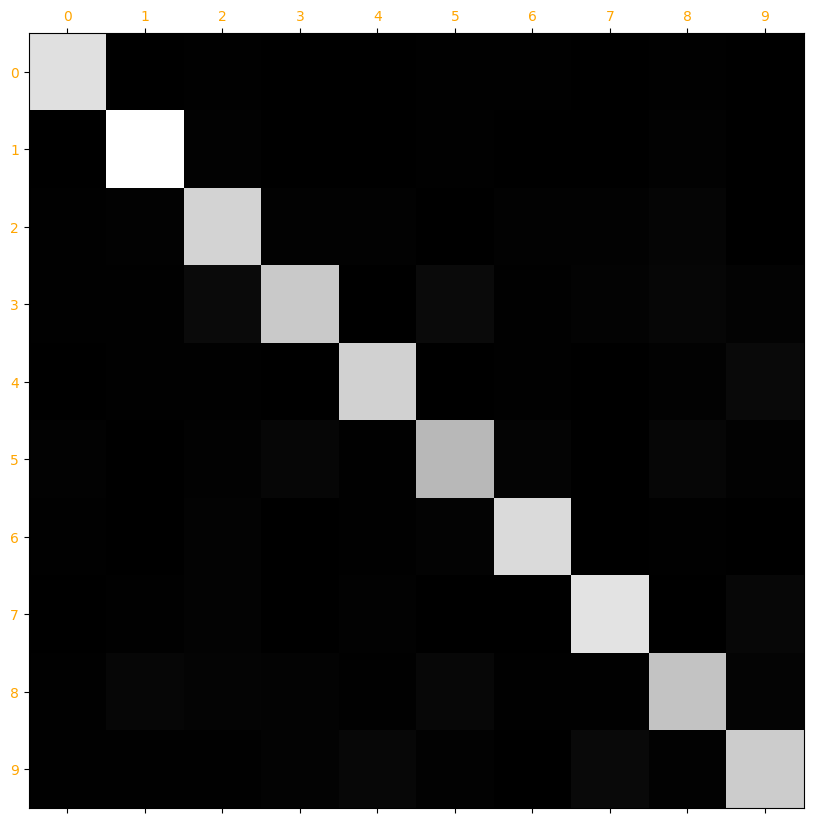

In [51]:
# To make matshow plot bigger, you must use figsize and fignum parameters
plt.figure(figsize=(10, 10))
plt.matshow(confusion_matrix, cmap="gray", fignum=1)
plt.yticks(np.arange(0, 10, step=1), color="orange")
plt.xticks(np.arange(0, 10, step=1), color="orange")
plt.show()

# in the figure below you see that we have white diagonal, which is good. But there are also spots in the remaining parts of the plot which are not completely dark, and we should focus on them.
# just a reminder, rows in the confusion matrix represent actual classes, and columns represent predicted classes

In [52]:
# It would be better to check if we have even number of items in each class, because if we have uneven number of items in each class, then the confusion matrix will not be accurate in the form which we plotted above.

unique, counts = np.unique(y_train, return_counts=True)

classes_sorted = [x for _, x in sorted(zip(counts, unique))]
counts_sorted = counts[classes_sorted]
print(f"Classes: {classes_sorted}")
print(f"Counts: {counts_sorted}")

Classes: [5, 4, 8, 6, 0, 9, 2, 3, 7, 1]
Counts: [5421 5842 5851 5918 5923 5949 5958 6131 6265 6742]


Row sums:
[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]

Normalised confusion matrix:
[[9.68090495e-01 3.37666723e-04 7.59750127e-03 1.85716698e-03
  1.85716698e-03 4.72733412e-03 5.06500084e-03 2.02600034e-03
  7.25983454e-03 1.18183353e-03]
 [1.48323939e-04 9.69296945e-01 8.00949273e-03 1.33491546e-03
  1.18659152e-03 5.04301394e-03 1.18659152e-03 1.77988727e-03
  1.02343518e-02 1.77988727e-03]
 [6.71366230e-03 9.23128567e-03 9.09197717e-01 9.06344411e-03
  1.14132259e-02 4.02819738e-03 9.56696878e-03 1.29237999e-02
  2.46727090e-02 3.18898959e-03]
 [5.05627141e-03 7.33974882e-03 4.24074376e-02 8.38199315e-01
  1.95726635e-03 4.33860708e-02 4.56695482e-03 1.37008645e-02
  2.83803621e-02 1.50057087e-02]
 [1.88291681e-03 5.13522766e-03 7.87401575e-03 1.19821979e-03
  9.15782266e-01 1.71174255e-03 7.01814447e-03 4.27935638e-03
  1.16398494e-02 4.34782609e-02]
 [1.05146652e-02 4.05829183e-03 1.30972145e-02 2.89614462e-02
  9.03892271e-03 8.67367644e-01 

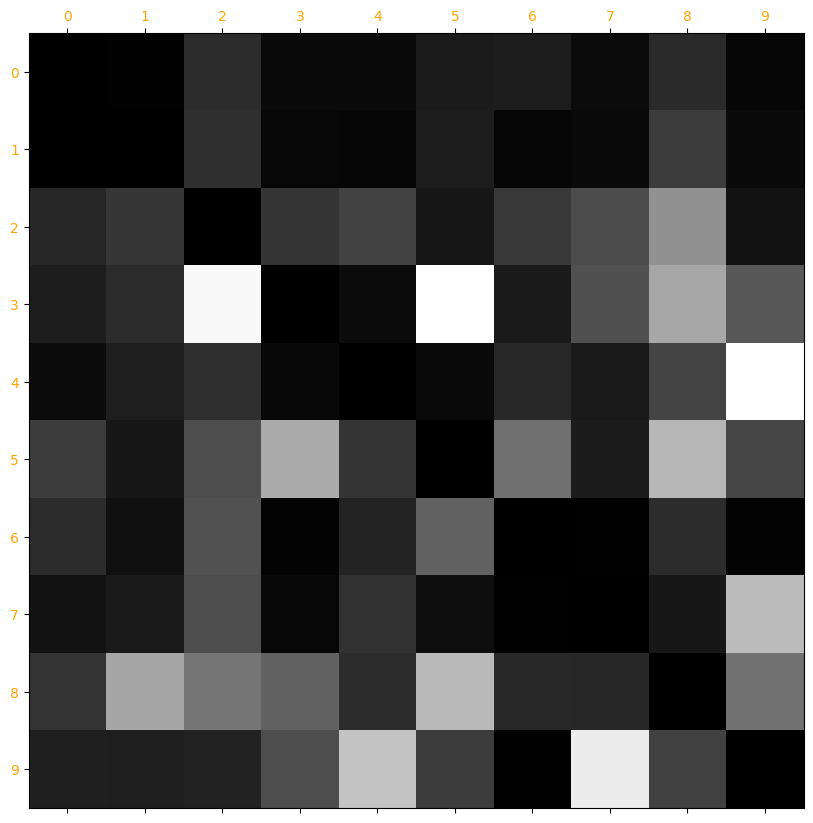

In [53]:
# correct the plot above to show not absolute numbers, but adjusted numbers based on the occurrence of each class 

# This makes the sum of each row (since all numbers in a given row in confusion matrix are total number of items in a given class)
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
print(f"Row sums:\n{row_sums}\n")

# Divide each number at a given row by the sum of that row
normalised_confusion_matrix = confusion_matrix / row_sums
print(f"Normalised confusion matrix:\n{normalised_confusion_matrix}\n")

# fill diagonal with 0s to keep only the errors
np.fill_diagonal(normalised_confusion_matrix, 0)

plt.figure(figsize=(10, 10))
plt.matshow(normalised_confusion_matrix, cmap="gray", fignum=1)
plt.yticks(np.arange(0, 10, step=1), color="orange")
plt.xticks(np.arange(0, 10, step=1), color="orange")
plt.show()

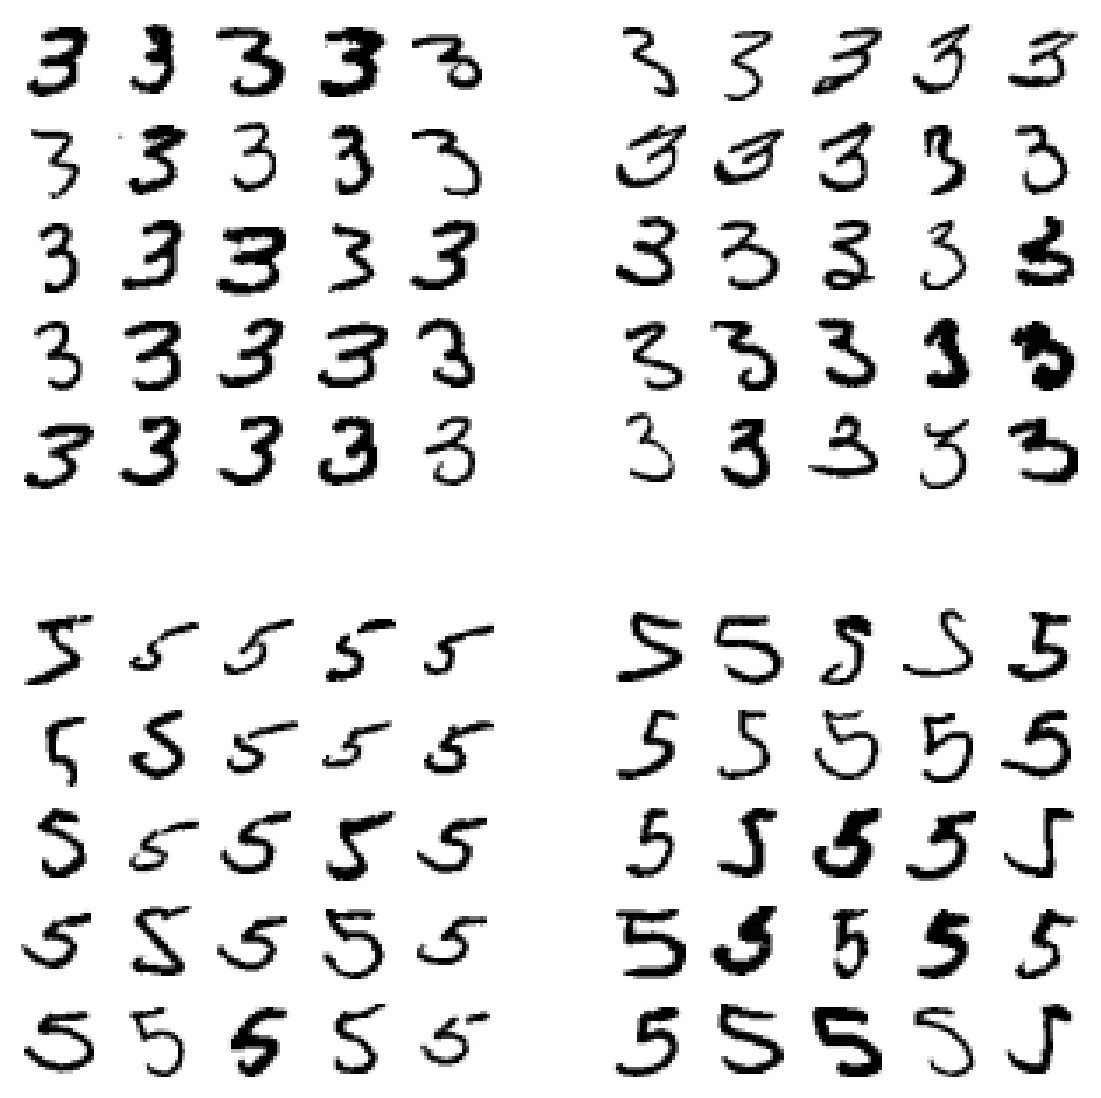

In [54]:
# This cell actually makes more sense on the results which are shown in the book. The author was trying to explain and visualise classification errors which were visible on his normalised confusion matrix plot. So to sum this up, my normalised confusion matrix is different compared to the book, but you can check the comparison of misclassified images below, which are very similar as in the book.

# filter out the data
class_3, class_5 = 3, 5
correct_predictions_3 = X_train[(y_train == class_3) & (y_train_predictions == class_3)]
classified_3_as_5 = X_train[(y_train == class_3) & (y_train_predictions == class_5)]
correct_predictions_5 = X_train[(y_train == class_5) & (y_train_predictions == class_5)]
classified_5_as_3 = X_train[(y_train == class_5) & (y_train_predictions == class_3)]

# create a figure with 4 subplots
plt.figure(figsize=(14, 14))

plt.subplot(221)  # top left
plot_digits(correct_predictions_3[:25], images_per_row=5)

plt.subplot(222)  # top right
plot_digits(classified_3_as_5[:25], images_per_row=5)

plt.subplot(223)  # bottom left
plot_digits(correct_predictions_5[:25], images_per_row=5)

plt.subplot(224)  # bottom right
plot_digits(classified_5_as_3[:25], images_per_row=5)
plt.show()

# MULTILABEL CLASSIFICAITON
example - face recognition program. Program has been trained to reckognize Alice, Bob and Charlie. Now when we show it picture where are together Alice and Charlie it should output [1, 0, 1] (Yes, No, Yes)

In [55]:
# some not in depth example
from sklearn.neighbors import KNeighborsClassifier

# create new labels by making boolean for number bigger than 6 and another boolean for odd number. This means that what once used to be one label (number from 0 to 9) is now two labels [is_bigger_than_6, is_odd]
y_train_bigger_than_6 = y_train >= 7
y_train_odd = y_train % 2 == 1

# np.c_ made here y_train_large the first column, and y_train_odd second in the same array
y_multilabel = np.c_[y_train_bigger_than_6, y_train_odd]

print(y_multilabel)

[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


In [56]:
k_nearest_neighbours_classifier = KNeighborsClassifier()
k_nearest_neighbours_classifier.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
# some_digit is 5, which is not bigger than 6 and it is odd
k_nearest_neighbours_classifier.predict([some_digit])

array([[False,  True]])

In [58]:
# example how to evaluate multilabel classification (using F1 score)
y_train_knn_predictions = cross_val_predict(
    estimator=k_nearest_neighbours_classifier,
    X=X_train,
    y=y_multilabel,
    cv=3
)

# average='macro' means that you want to compute the average of the F1 score of each label, giving equal weight to each label. If you want to give each label a weight proportional to its support (some labels have more instances than others), you can set average='weighted' instead.
print(f"F1 score: {f1_score(y_true=y_multilabel, y_pred=y_train_knn_predictions, average='macro')}")

F1 score: 0.9764102655606048


# MULTIOUTPUT CLASSIFICATION
In this example we will create a simple model capable of removing noise from artificially changed MNIST images.\
What does multioutput classification mean?\
On the example below, the prediction will have number of labels equal to number of pixels in the image. On top of that, each pixel will have a value from 0 to 255.

In [59]:
# create noise
noise = np.random.randint(low=0, high=150, size=(len(X_train), 784))
X_train_with_noise = X_train + noise

noise = np.random.randint(0, 150, (len(X_test), 784))
X_test_with_noise = X_test + noise

y_train_clean = X_train
y_test_clean = X_test

print(max(X_train_with_noise[0]))

# the lower the number of pixel, the lighter the pixel is. The higher the number of pixel, the darker the pixel is. 
# Note: If you are using the dark theme of IDE and color map that only works with black and white, the resulting plots might have inverted colors compared to the real image.
# You see that the max number is higher than 255, I think that matplotlib is doing some kind of normalization.

401


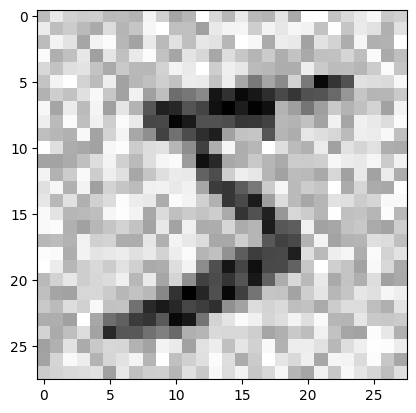

In [60]:
# with noise
plt.imshow(X_train_with_noise[0].reshape((28, 28)), cmap="binary")

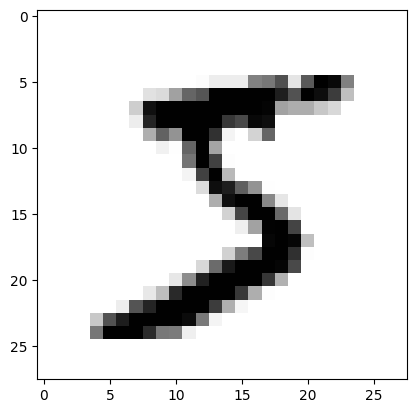

In [61]:
# original image which is now label to the one with noise
plt.imshow(y_train_clean[0].reshape((28, 28)), cmap="binary")

array([ 51, 206, 182,  69, 253, 108,  89, 126, 185,   0, 245, 180,  11,
       195, 172, 232, 138,  36,  40,  11, 108, 123,   9, 113, 248, 142,
        61,  60,  94, 223, 232,   7, 166, 187,  98,  26,  69,  16, 181,
        20, 227,  74, 249, 109, 178,  67,  62, 112, 238,  54, 146, 141,
        34, 154, 216, 155,  92,  66,  95, 242, 236, 186,  11, 228,   2,
        19,  14,  70, 252, 161,  77, 232, 147, 232,  46, 214,  31,  38,
       155,  40, 177,  48, 224, 208,  69,  17, 165, 166, 246, 126,  27,
       233,   2, 218,  53, 230, 135, 210,  39, 218, 225, 211, 126, 222,
       144, 182, 206, 148, 188, 138, 183, 241, 224,  40, 195,  26, 169,
       216,   4, 109, 221,  65, 130,  39,  83,  81, 124, 248,  58,  69,
       129, 109,  44,   0, 135,  18,  91, 185,  78, 172,  44, 197, 210,
       108, 139,  45,  82,  71,  47,  56,  66,  66,  69, 241,  90,  89,
       152, 370, 409,  62, 274, 397, 379, 381,  82,  62,   6,  62,  74,
       166,  51, 180, 136, 112,  37,  85, 164,  51, 168, 280, 25

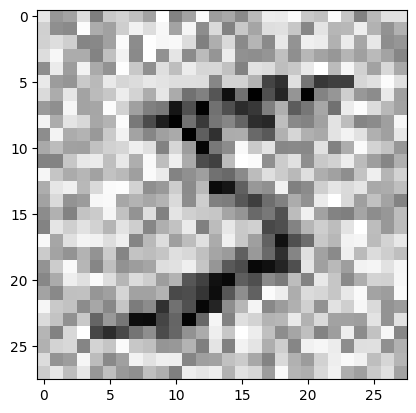

In [62]:
# In case you want to add some noise to the single image, it seems that you have to assign individual random value to
# each pixel (instead of adding the same number to all pixels), otherwise it will just offset the whole image and the 
# ratios will stay the same, meaning the image will look the same.
result = []
for pixel in y_train_clean[0]:
    result += [pixel + np.random.randint(0, 255)]
result = np.array(result)
plt.imshow(result.reshape((28, 28)), cmap="binary")
result

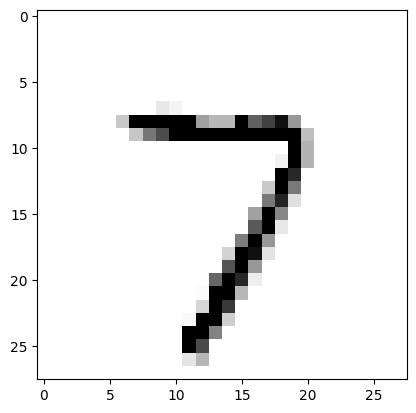

In [63]:
# predict
k_nearest_neighbours_classifier.fit(X_train_with_noise, y_train_clean)
clean_digit = k_nearest_neighbours_classifier.predict([X_test_with_noise[0]])
plt.imshow(clean_digit.reshape((28, 28)), cmap="binary")

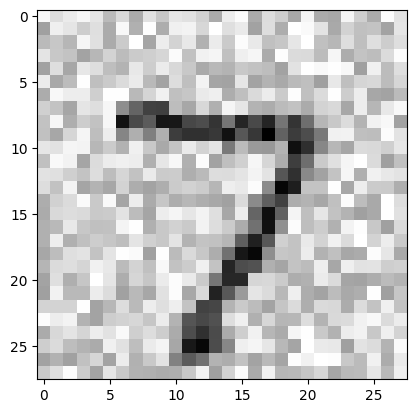

In [64]:
# former image
plt.imshow(X_test_with_noise[0].reshape((28, 28)), cmap="binary")

# EXTRA MATERIAL

First indexes of shifted image down:
[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


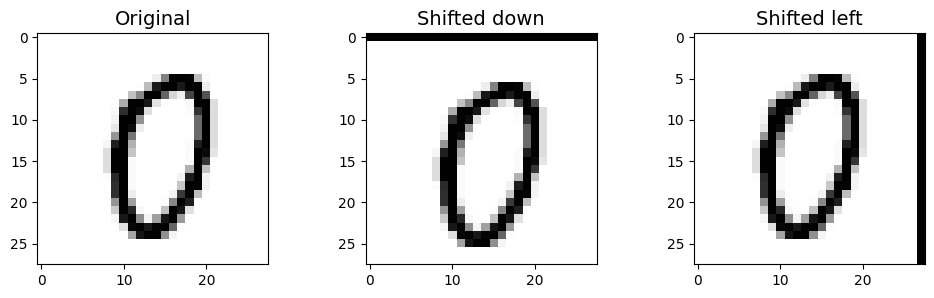

In [65]:
# CREATE A FUNCTION WHICH SHIFTS THE IMAGE BY ONE PIXEL TO EACH SIDE

# Aim is to expand the dataset with artificially created images
from scipy.ndimage import shift


def shift_image(image: np.array,
                shift_x_axis_pixels: int,
                shift_y_axis_pixels: int,
                shape: tuple,
                fill_value: int = 0):
    """
    Take a 1D array, reshape it to 2D array, shift it by specified number of pixels and reshape it back to 1D array.
    :param shift_x_axis_pixels: Number of pixels to shift. Can be also negative number.
    :param shift_y_axis_pixels: Number of pixels to shift. Can be also negative number.
    :param fill_value: Numbers to fill the empty space with.
    :return: 
    """
    image = image.reshape(shape)
    shifted_image = shift(
        input=image,
        shift=(shift_y_axis_pixels, shift_x_axis_pixels),
        # with order 0, the original numbers are preserved. With order > 0 the numbers are somehow changed, but ratios are preserved I guess. It is not important to understand it at the moment, but keep it in mind.
        order=0,
        cval=fill_value
    )
    # reshape -1 flattens the array into 1D array
    return shifted_image.reshape(-1)


image = X_train[1000]
shifted_image_down = shift_image(image=image,
                                 shift_x_axis_pixels=0,
                                 shift_y_axis_pixels=1,
                                 shape=(28, 28),
                                 fill_value=255)
print(f"First indexes of shifted image down:\n{shifted_image_down[0:50]}")
shifted_image_left = shift_image(image=image,
                                 shift_x_axis_pixels=-1,
                                 shift_y_axis_pixels=0,
                                 shape=(28, 28),
                                 fill_value=255)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), cmap="Greys")
plt.show()

# See that we can fill the newly created empty space with whatever values we want. In this case we shift if only by one pixel to a certain direction, therefore the first row or columns is filled with 28 new values (255). This also results into a white/black strip on the side of the image. (depending on the theme of IDE)
# Normally you would of course fill the new indexes with values you need, like for example 0s in this case. But for 
# demonstration purpouses, the value is here explicitly set to 255, to show the difference between the original and shifted image.

In [66]:
X_train_augmented = X_train.tolist()
y_train_augmented = y_train.tolist()

# append to existing dataset 4 new images (shifted to each side by one pixel) for each original image, and fill the empty space with 0s
for pixels_x_axis, pixels_y_axis in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image=image,
                                             shift_x_axis_pixels=pixels_x_axis,
                                             shift_y_axis_pixels=pixels_y_axis,
                                             shape=(28, 28),
                                             fill_value=0))
        y_train_augmented.append(label)

# convert from list back to numpy array
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [67]:
print(f"X_train_augmented shape: {X_train_augmented.shape}")
print(f"y_train_augmented shape: {y_train_augmented.shape}")

X_train_augmented shape: (300000, 784)
y_train_augmented shape: (300000,)


In [68]:
# shuffle the data
shuffled_indexes = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffled_indexes]
y_train_augmented = y_train_augmented[shuffled_indexes]

In [69]:
# scale the data
scaler = MinMaxScaler()
X_train_augmented_scaled = scaler.fit_transform(X_train_augmented.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

In [70]:
#-----------------------------------------------------------------------------------------------

In [71]:
# CREATE A CLASSIFIER ON MNIST DATASET WITH OVER 97% ACCURACY
# TODO: try also author's approach with grid search
# In the book, author used grid search to find the best hyperparameters for the model. I will not do that, because it takes too long to run (16 hrs). I will use extended dataset I created in the cells above where the images are shifted by a pixel to each side.

from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_augmented_scaled, y_train_augmented)

y_train_predictions = cross_val_predict(knn_clf, X_train_augmented_scaled, y_train_augmented, cv=3)
accuracy = accuracy_score(y_train_augmented, y_train_predictions)
precisions = precision_score(y_train_augmented, y_train_predictions, average="macro")
recalls = recall_score(y_train_augmented, y_train_predictions, average="macro")

print("Predictions on train data:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precisions}")
print(f"Recall: {recalls}")

Predictions on train data:
Accuracy: 0.9794033333333333
Precision: 0.9798836532951501
Recall: 0.9790851742214717


In [72]:
# reminder that we are going to work with only a subset of the dataset, which we have not seen before
print(X_test_scaled.shape)
print(y_test.shape)

(10000, 784)
(10000,)


In [73]:
# predictions on unseen data
predictions = knn_clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, predictions)
precisions = precision_score(y_test, predictions, average="macro")
recalls = recall_score(y_test, predictions, average="macro")

print("Predictions on test data:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precisions}")
print(f"Recall: {recalls}")

Predictions on test data:
Accuracy: 0.9754
Precision: 0.9758214273716403
Recall: 0.9751070040023555


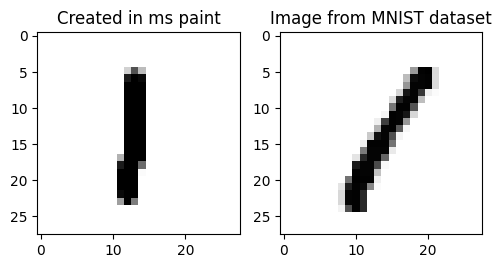

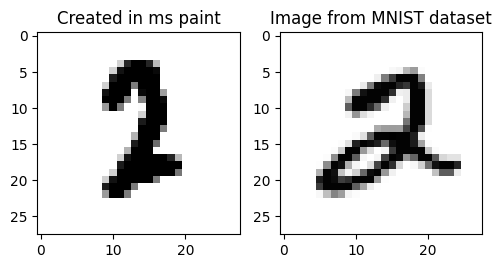

In [74]:
# just to be really sure that that the predictions are indeed ok on unseen data, I created few images in ms paint and tested predictions on them. The predictions were correct.

# load image from folder as a numpy array
from PIL import Image, ImageOps

images = []
for i in range(10):
    image = Image.open(rf"saved_datasets\MNIST\{i}.png")
    # for some reason grayscale conversion converts it exactly in the opposite I want, therefore I have to invert it again
    image = ImageOps.grayscale(image)
    image = ImageOps.invert(image)
    image = np.array(image)
    # estimator was trained on scaled data, therefore we have to scale the image as well
    image = scaler.fit_transform(image.astype(np.float64))
    images.append(image)

plt.figure(figsize=(12, 4))
plt.subplot(141)
plt.title("Created in ms paint")
plt.imshow(images[1], cmap="Greys")
plt.subplot(142)
plt.title("Image from MNIST dataset")
plt.imshow(X_train[3].reshape(28, 28), cmap="Greys")

plt.figure(figsize=(12, 4))
plt.subplot(143)
plt.title("Created in ms paint")
plt.imshow(images[2], cmap="Greys")
plt.subplot(144)
plt.title("Image from MNIST dataset")
plt.imshow(X_train[5].reshape(28, 28), cmap="Greys")

# On the plots below you see that images created in ms paint are slightly thicker but still the estimator has no problem to classify them correctly.

In [75]:
for i in range(10):
    prediction = knn_clf.predict([images[i].reshape(784)])[0]
    print(f"Actual: {i},",
          f"Predicted: {prediction},",
          f"{i == prediction}"
          )

Actual: 0, Predicted: 0, True
Actual: 1, Predicted: 1, True
Actual: 2, Predicted: 2, True
Actual: 3, Predicted: 3, True
Actual: 4, Predicted: 4, True
Actual: 5, Predicted: 5, True
Actual: 6, Predicted: 5, False
Actual: 7, Predicted: 7, True
Actual: 8, Predicted: 8, True
Actual: 9, Predicted: 9, True


In [76]:
# save model
import joblib

joblib.dump(knn_clf, r"saved_models\MINST_KNearestNeighboursClassifier.pkl")

['saved_models\\MINST_KNearestNeighboursClassifier.pkl']

In [77]:
#-----------------------------------------------------------------------------------------------

In [10]:
# TITANIC DATASET CLASSIFICATION
# The goal is to predict whether a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

# TODO: The dataset is no longer available at my side. Needs to be downloaded.
train_data = pd.read_csv(r"saved_datasets\titanic\train.csv")
test_data = pd.read_csv(r"saved_datasets\titanic\test.csv")

# The data is already split into a training set and a test set. However, the test data does not contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

In [11]:
# check the data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId: a unique identifier for each passenger
Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
Pclass: passenger class.
Name, Sex, Age: self-explanatory
SibSp: how many siblings & spouses of the passenger aboard the Titanic.
Parch: how many children & parents of the passenger aboard the Titanic.
Ticket: ticket id
Fare: price paid (in pounds)
Cabin: passenger's cabin number
Embarked: where the passenger embarked the Titanic

In [13]:
# explicitly set the PassengerId column as the index column
train_data.set_index("PassengerId", inplace=True)
test_data.set_index("PassengerId", inplace=True)
train_data.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [82]:
print(f"Median age woman: {train_data[train_data['Sex'] == 'female']['Age'].median()}")
print(f"Median age man: {train_data[train_data['Sex'] == 'male']['Age'].median()}")


Median age woman: 27.0
Median age man: 29.0


In [83]:
# check numerical attributes
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [84]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [85]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [86]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [87]:
# The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [88]:
# create pipelines for numerical and categorical attributes

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [92]:
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False)),
])

In [93]:
# create a full pipeline which will combine both numerical and categorical pipelines

from sklearn.compose import ColumnTransformer

numeric_attributes = ["Age", "SibSp", "Parch", "Fare"]
categorical_attributes = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", numerical_pipeline, numeric_attributes),
    ("cat", categorical_pipeline, categorical_attributes),
])

In [94]:
# filter out only the most important attributes/features
X_train = preprocess_pipeline.fit_transform(
    train_data[numeric_attributes + categorical_attributes])

# print out what columns are now in the dataset
print(X_train[0])

[-0.56573582  0.43279337 -0.47367361 -0.50244517  0.          0.
  1.          0.          1.          0.          0.          1.        ]


In [95]:
# create labels
y_train = train_data["Survived"]

In [96]:
# train a classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [97]:
# predict on test data

X_test = preprocess_pipeline.transform(test_data[numeric_attributes + categorical_attributes])
y_pred = forest_clf.predict(X_test)

In [98]:
# evaluate the model

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(
    estimator=forest_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring="accuracy"
)

print(f"Accuracy RandomForest: {forest_scores.mean()}")

Accuracy RandomForest: 0.8137578027465668


In [99]:
# try another model

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)

print(f"Accuracy SVM: {svm_scores.mean()}")

Accuracy SVM: 0.8249313358302123


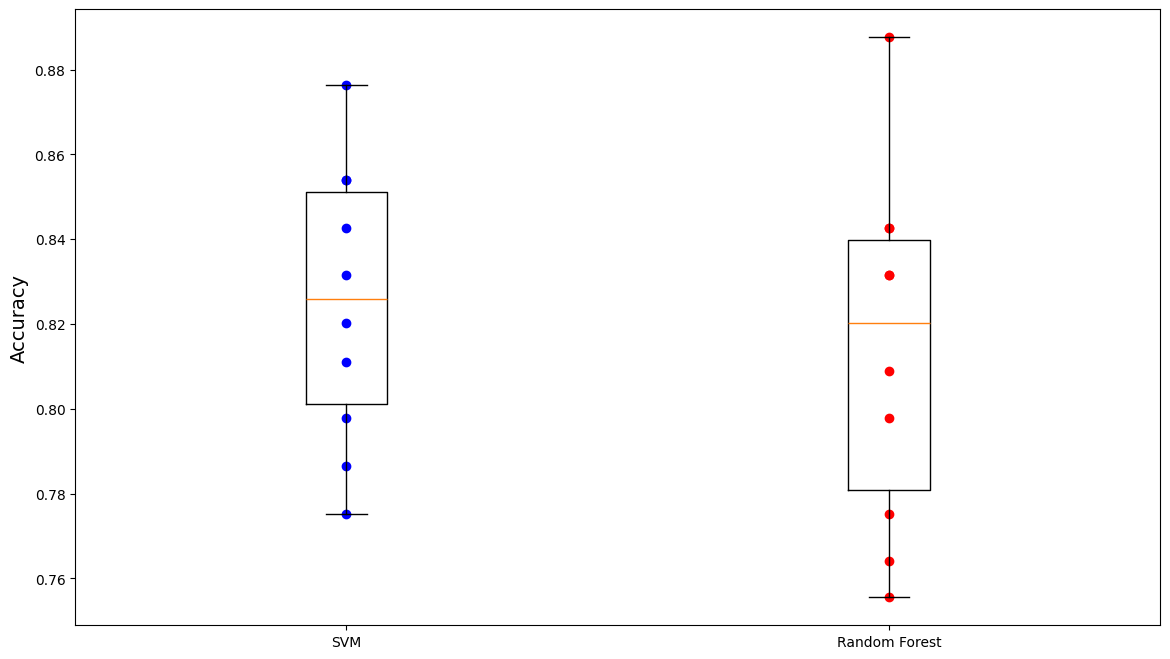

In [100]:
plt.figure(figsize=(14, 8))
plt.plot([1] * 10, svm_scores, "bo")
plt.plot([2] * 10, forest_scores, "ro")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

# The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

To improve this result further, you could:

- Compare many more models and tune hyperparameters using cross validation and grid search,
- Do more feature engineering, for example:
    -> Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
    -> Replace SibSp and Parch with their sum.
    -> Try to identify parts of names that correlate well with the Survived attribute.
    -> Use the Cabin column, for example take its first letter and treat it as a categorical attribute.

In [101]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [102]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [103]:
numeric_attributes = ["Age", "SibSp", "Parch", "Fare"]
categorical_attributes = ["Pclass", "Sex", "Embarked", "AgeBucket", "RelativesOnboard"]

preprocess_pipeline = ColumnTransformer([
    ("num", numerical_pipeline, numeric_attributes),
    ("cat", categorical_pipeline, categorical_attributes),
])
X_train = preprocess_pipeline.fit_transform(
    train_data[numeric_attributes + categorical_attributes]
)

In [104]:
# let's try a few different models and see how they perform

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(
    estimator=forest_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring="accuracy"
)

print(f"Accuracy RandomForest: {forest_scores.mean()}")

Accuracy RandomForest: 0.7991635455680399


In [105]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)

print(f"Accuracy SVM: {svm_scores.mean()}")

Accuracy SVM: 0.8294257178526842


In [106]:
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)

print(f"Accuracy KNN: {knn_scores.mean()}")

Accuracy KNN: 0.7946441947565543


In [107]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_clf = DecisionTreeClassifier()
decision_tree_scores = cross_val_score(decision_tree_clf, X_train, y_train, cv=10)

print(f"Accuracy Decision Tree: {decision_tree_scores.mean()}")

Accuracy Decision Tree: 0.7890012484394507


In [108]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10)

print(f"Accuracy SGD: {sgd_scores.mean()}")

Accuracy SGD: 0.7710611735330837


In [109]:
# run grid search on support vector machine classifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        "kernel": ["linear", "rbf"],
        "C": [0.05, 0.1, 0.5, 0.8, 0.9, 1, 5, 10, 100],
        "gamma": ["scale", "auto"]
    }
]

grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    return_train_score=True,
    verbose=2
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .................C=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..................C=0.05, gamma=auto, 

In [110]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [111]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# below you see many of the parameters you could theoretically use in grid search on support vector classifier. Before running this parameter grid, you should obviously check which parameters do actually make sense to use (here they were just put all together randomly). Nevertheless, when I run this cell, it ran so long that I had to terminate it.
parameters = [{
    'C': [0.05, 0.1, 0.5, 0.8, 0.9, 1, 5, 10, 100],
    'break_ties': [False],
    'cache_size': [200],
    'class_weight': ["balanced", None],
    'coef0': [0.0, 0.2, 0.5, 1.0],
    'decision_function_shape': ["ovo", "ovr"],
    'degree': [1, 2, 3],
    'gamma': ['scale', 'auto'],
    'kernel': ["linear", "poly", "rbf", "sigmoid"],
    'max_iter': [-1],
    'probability': [False],
    'random_state': [42],
    'shrinking': [False, True],
    'tol': [0.001, 0.01, 0.1],
    'verbose': [False]
}]

# UNCOMMENT IF YOU WANT TO RUN IT
# grid_search = GridSearchCV(
#     estimator=SVC(),
#     param_grid=parameters,
#     cv=5,
#     scoring="accuracy",
#     return_train_score=True,
#     verbose=2
# )
# 
# grid_search.fit(X_train, y_train)
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best estimator: {grid_search.best_estimator_}")
# print(f"Best score: {grid_search.best_score_}")

In [112]:
#-----------------------------------------------------------------------------------------------

# SPAM CLASSIFIER
ham email - email which is not spam
spam email - email which is malicious or unwanted

In [113]:
import os
import tarfile

DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"
SPAM_PATH = r"saved_datasets\spam"
HAM_SOURCE = SPAM_PATH + r"\20030228_easy_ham.tar.bz2"
SPAM_SOURCE = SPAM_PATH + r"\20030228_spam.tar.bz2"
HAM_EXTRACT = SPAM_PATH + r"\easy_ham"
SPAM_EXTRACT = SPAM_PATH + r"\spam"

# extract the data
tar_bz2_file = tarfile.open(SPAM_SOURCE)
tar_bz2_file.extractall(path=SPAM_PATH)
tar_bz2_file.close()
tar_bz2_file = tarfile.open(HAM_SOURCE)
tar_bz2_file.extractall(path=SPAM_PATH)
tar_bz2_file.close()

# get the filenames into lists
spam_filenames = [name for name in sorted(os.listdir(SPAM_EXTRACT)) if len(name) > 20]
ham_filenames = [name for name in sorted(os.listdir(HAM_EXTRACT)) if len(name) > 20]
print(f"{spam_filenames[:5]=}")

spam_filenames[:5]=['00001.7848dde101aa985090474a91ec93fcf0', '00002.d94f1b97e48ed3b553b3508d116e6a09', '00003.2ee33bc6eacdb11f38d052c44819ba6c', '00004.eac8de8d759b7e74154f142194282724', '00005.57696a39d7d84318ce497886896bf90d']


In [114]:
len(ham_filenames)

2500

In [115]:
len(spam_filenames)

500

In [116]:
# use Python's email module to parse these emails (this handles headers, encoding, and so on):

import email
import email.policy


def load_email(is_spam: bool,
               filename: str,
               spam_path: str = SPAM_PATH) -> email.message.EmailMessage:
    """
    Load email from file.
    
    :param is_spam: User must specify whether the email is spam or not. 
    :param filename: Name of the file to load.
    :param spam_path: Root path to spam datasets.
    :return: email.message.EmailMessage
    """
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)

In [117]:
# load "email objects" into lists
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [118]:
# let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [119]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [120]:
# some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

# If you want you can spend more time on this and try to understand and document what is going on here.
def get_email_structure(email_: email.message.EmailMessage) \
        -> str | email.message.EmailMessage:
    """
    Get email structure.

    :param email_: email.message.EmailMessage
    :return: str | email.message.EmailMessage
    """
    if isinstance(email_, str):
        return email_

    # To explain what payload is, let's take a look at the example below:
    # from email.parser import Parser
    # headers = "From: user@example.com\nTo: recipient@example.com\nSubject: Test email\n\n"
    # body = "Hello, this is a test email."
    # email_message = Parser().parsestr(headers + body)
    # In this example, get_payload() will return the string "Hello, this is a test email.", which is the body of the email.
    payload = email_.get_payload()

    if isinstance(payload, list):
        sub_email_structures = []
        for sub_email in payload:
            sub_email_structure = get_email_structure(email_=sub_email)
            sub_email_structures.append(sub_email_structure)

        return f"MultipartEmail({', '.join(sub_email_structures)})"
    else:
        return email_.get_content_type()


In [121]:
from collections import Counter


def structures_counter(emails: list) -> Counter:
    """
    Count email structures.
    
    :param emails: List of emails.
    :return: Counter
    """
    structures = Counter()
    for email_ in emails:
        structure = get_email_structure(email_)
        structures[structure] += 1
    return structures

In [122]:
# If I understand it correctly, (also mentioned by book author) there are emails which have inside them another emails, therefore MultipartEmail(MultipartEmail()...)
# So below you see summary of what types of emails we have in the dataset.
for structure in structures_counter(ham_emails).most_common():
    print(structure)

('text/plain', 2408)
('MultipartEmail(text/plain, application/pgp-signature)', 66)
('MultipartEmail(text/plain, text/html)', 8)
('MultipartEmail(text/plain, text/plain)', 4)
('MultipartEmail(text/plain)', 3)
('MultipartEmail(text/plain, application/octet-stream)', 2)
('MultipartEmail(text/plain, text/enriched)', 1)
('MultipartEmail(text/plain, application/ms-tnef, text/plain)', 1)
('MultipartEmail(MultipartEmail(text/plain, text/plain, text/plain), application/pgp-signature)', 1)
('MultipartEmail(text/plain, video/mng)', 1)
('MultipartEmail(text/plain, MultipartEmail(text/plain))', 1)
('MultipartEmail(text/plain, application/x-pkcs7-signature)', 1)
('MultipartEmail(text/plain, MultipartEmail(text/plain, text/plain), text/rfc822-headers)', 1)
('MultipartEmail(text/plain, MultipartEmail(text/plain, text/plain), MultipartEmail(MultipartEmail(text/plain, application/x-pkcs7-signature)))', 1)
('MultipartEmail(text/plain, application/x-java-applet)', 1)


In [123]:
# spam emails content types
for structure in structures_counter(spam_emails).most_common():
    print(structure)

('text/plain', 218)
('text/html', 183)
('MultipartEmail(text/plain, text/html)', 45)
('MultipartEmail(text/html)', 20)
('MultipartEmail(text/plain)', 19)
('MultipartEmail(MultipartEmail(text/html))', 5)
('MultipartEmail(text/plain, image/jpeg)', 3)
('MultipartEmail(text/html, application/octet-stream)', 2)
('MultipartEmail(text/plain, application/octet-stream)', 1)
('MultipartEmail(text/html, text/plain)', 1)
('MultipartEmail(MultipartEmail(text/html), application/octet-stream, image/jpeg)', 1)
('MultipartEmail(MultipartEmail(text/plain, text/html), image/gif)', 1)
('multipart/alternative', 1)


It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

In [124]:
# email headers, aka some metadata
spam_emails[0].items()

[('Return-Path', '<12a1mailbot1@web.de>'),
 ('Delivered-To', 'zzzz@localhost.spamassassin.taint.org'),
 ('Received',
  'from localhost (localhost [127.0.0.1])\tby phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32\tfor <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)'),
 ('Received',
  'from mail.webnote.net [193.120.211.219]\tby localhost with POP3 (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)'),
 ('Received',
  'from dd_it7 ([210.97.77.167])\tby webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623\tfor <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100'),
 ('From', '12a1mailbot1@web.de'),
 ('Received',
  'from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);\t Sat, 24 Aug 2002 09:42:10 +0900'),
 ('To', 'dcek1a1@netsgo.com'),
 ('Subject', 'Life Insurance - Why Pay More?'),
 ('Date', 'Wed, 21 Aug 2002 20:31:57 -1600'),
 ('MIME-Version', '1.0'),
 ('Message-ID', '<0103c104200

In [125]:
# let's take a look at the email headers:
for header, value in spam_emails[0].items():
    print(f"{header}:", value, end="\n\n")

Return-Path: <12a1mailbot1@web.de>

Delivered-To: zzzz@localhost.spamassassin.taint.org

Received: from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)

Received: from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)

Received: from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100

From: 12a1mailbot1@web.de

Received: from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900

To: dcek1a1@netsgo.com

Subject: Life Insurance - Why Pay More?

Date: Wed, 21 Aug 2002 20:31:57 -1600

MIME-Version: 1.0

Message-ID: <0103c1042001882DD_IT7@dd_it7>

Content-Type: text/html; charset="iso-8859-1"

Content-Transfer-Encoding: quo

In [126]:
# There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the Subject header:
print("From:", spam_emails[0]["From"])
print("Subject:", spam_emails[0]["Subject"])

From: 12a1mailbot1@web.de
Subject: Life Insurance - Why Pay More?


In [127]:
# split the data into a training set and a test set.

from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great BeautifulSoup library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment). The following function first drops the <head> section, then converts all <a> tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as &gt; or &nbsp;):

In [128]:
from typing import AnyStr
import re
from html import unescape


# If you want, you can spend more time on this and try to understand and document what is going on here in detail. But to understand it briefly, just look a few cells below, where is original and then result after regex of this function. It basically removes the html trash and leaves only the text.
def html_to_plain_text(html) -> AnyStr:
    """
    Convert html to plain text.
    :param html: 
    :return: 
    """
    text = re.sub(
        "<head.*?>.*?</head>",
        repl='',
        string=html,
        flags=re.M | re.S | re.I
    )
    text = re.sub(
        '<a\s.*?>',
        repl=' HYPERLINK ',
        string=text,
        flags=re.M | re.S | re.I
    )
    text = re.sub(
        '<.*?>',
        repl='',
        string=text,
        flags=re.M | re.S
    )
    text = re.sub(
        r'(\s*\n)+',
        repl='\n',
        string=text,
        flags=re.M | re.S)
    return unescape(text)

In [129]:
html_spam_emails = [email for email in X_train[y_train == 1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]

# email before regex
print(sample_html_spam.get_content().strip())

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [130]:
# You can find this text above. But above, there is a lot of junk we do not need anymore. This function removes the junk and leaves only the text.
print(html_to_plain_text(sample_html_spam.get_content()))


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [131]:

def email_to_text(email):
    """
    Function that takes an email as input and returns its content as plain text, whatever its format is.
    
    :param email: 
    :return: 
    """
    html = None
    for part in email.walk():
        content_type = part.get_content_type()
        if not content_type in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:  # in case of encoding issues
            content = str(part.get_payload())
        if content_type == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [132]:
print(email_to_text(sample_html_spam))


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Let's throw in some stemming! For this to work, you need to install the Natural Language Toolkit (NLTK). It's as simple as running the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the --user option):

In [133]:
# !pip install nltk

try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Error: stemming requires the NLTK module.


We will also need a way to replace URLs with the word "URL". For this, we could use hard core regular expressions but we will just use the urlextract library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the --user option):

In [134]:
# !pip install urlextract

# this functionality is able to extract urls from text
try:
    import urlextract  # may require an Internet connection to download root domain names

    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls(
        "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
    ))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's split() method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [135]:
from sklearn.base import BaseEstimator, TransformerMixin


class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    """
    This class will take a list of emails and transform it into a list of Counter dictionaries, where each Counter indicates how many times each word appears in an email. Words are sorted by their number of occurrences in a given email. Also, there is done some preprocessing on the emails like replacing numbers with word NUMBER and so on.
    """
    def __init__(
            self,
            strip_headers=True,
            lower_case=True,
            remove_punctuation=True,
            replace_urls=True,
            replace_numbers=True,
            stemming=True,
            personal_printing_to_console=False
    ):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        self.personal_printing_to_console = personal_printing_to_console

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            # if the result of the function is not True, return empty string
            text = email_to_text(
                email) or ""

            # makes all letters lower case
            if self.lower_case:
                text = text.lower()

            # replaces all urls with the word "URL"    
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")

            # replaces all numbers with the word "NUMBER"
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)

            # removes all punctuation like .,!? etc. The place which was removed is replaced with a empty space.
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)

            word_counts = Counter(text.split())
            if self.personal_printing_to_console:
                print("Word counts in a given email:\n", word_counts)

            # use stemming on words in already created word_counts which holds number of occurrences of each word in a given email. In the for loop create then a new container which will hold again occurences of each word in a given email, but this time with stemmed words. Example of stemming is few cells above.
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count

                word_counts = stemmed_word_counts
                if self.personal_printing_to_console:
                    print("Stemmed word counts in a given email:\n", word_counts,
                          end="\n" + "=" * 75 + "\n\n")

            X_transformed.append(word_counts)
            
        if self.personal_printing_to_console:  
            print("End result of the whole transformation from EmailToWordCounterTransformer class. It is the list of Counters:\n", X_transformed)
        return np.array(X_transformed)

In [136]:
# Let's try this transformer on a few emails:
X_few = X_train[:6]
X_few_wordcounts = EmailToWordCounterTransformer(
    personal_printing_to_console=True
).fit_transform(X_few)


Word counts in a given email:
 Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1})
Word counts in a given email:
 Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christianity': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'one': 2, 'on': 2, 'been': 2, 'has': 2, 'half': 2, 'jesus': 2, 'some': 1, 'interesting': 1, 'quotes': 1, 'http': 1, 'www': 1, 'postfun': 1, 'com': 1, 'pfp': 1, 'worbois': 1, 'html': 1, 'thomas': 1, 'examined': 1, 'known': 1, 'superstitions': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'superstition': 1, 'redeeming': 1, 'feature': 1, 'they': 1, 'are': 1, 'alike': 1, 'founded': 1, 'fables': 1, 'mythology': 1, 'millions': 1, 'innocent': 1, 'men': 1, 'women': 1, 'children': 1, 'since': 1, 'introduction': 1, 'burnt': 1, 'tortured': 1, 'fined': 1, 'imprisoned': 1, 'what': 1, 'effect': 1, 'this': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fools': 1, 'other': 1, 'hypocrites': 1, 'support': 1, 'roguery':

In [137]:
print("Number of unique words in a given email:", len(X_few_wordcounts[0]))

for i, individual_word_count in enumerate(X_few_wordcounts[0].most_common()):
    print(i, individual_word_count)

# Below you see how many times each word in a given email appeared in that email.

Number of unique words in a given email: 6
0 ('chuck', 1)
1 ('murcko', 1)
2 ('wrote', 1)
3 ('stuff', 1)
4 ('yawn', 1)
5 ('r', 1)


In [138]:
for word_count in X_few_wordcounts:
    # the lists are longer, so lets take only the first most common words of each email
    print(word_count.most_common(10))
    
print("\n", "=" * 75, end="\n\n")

print(f"Unsorted contents of counters:", end="\n\n")
for word_count in X_few_wordcounts:
    print(word_count.items(), end="\n\n")

[('chuck', 1), ('murcko', 1), ('wrote', 1), ('stuff', 1), ('yawn', 1), ('r', 1)]
[('the', 11), ('of', 9), ('and', 8), ('all', 3), ('christianity', 3), ('to', 3), ('by', 3), ('jefferson', 2), ('i', 2), ('have', 2)]
[('NUMBER', 5), ('http', 4), ('yahoo', 4), ('s', 3), ('com', 3), ('to', 3), ('in', 2), ('forteana', 2), ('martin', 2), ('an', 2)]
[('to', 6), ('anthony', 2), ('i', 2), ('py', 2), ('a', 2), ('or', 2), ('it', 2), ('skip', 1), ('montanaro', 1), ('baxter', 1)]
[('a', 8), ('the', 6), ('tony', 5), ('folder', 5), ('NUMBER', 4), ('exmh', 4), ('in', 3), ('you', 3), ('users', 3), ('on', 2)]
[('razor', 10), ('NUMBER', 8), ('i', 8), ('this', 6), ('net', 6), ('users', 6), ('lists', 6), ('the', 5), ('a', 5), ('spamassassin', 4)]


Unsorted contents of counters:

dict_items([('chuck', 1), ('murcko', 1), ('wrote', 1), ('stuff', 1), ('yawn', 1), ('r', 1)])

dict_items([('some', 1), ('interesting', 1), ('quotes', 1), ('http', 1), ('www', 1), ('postfun', 1), ('com', 1), ('pfp', 1), ('worbois', 

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose fit() method will build the vocabulary (an ordered list of the most common words) and whose transform() method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [139]:
from scipy.sparse import csr_matrix

# 
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    """
    This class will take a list of Counters, where each counter contains each word with all its occurrences in a given email. Then it will create a vocabulary, which is a dictionary of the most common words (default 1000 most common words) across all emails. Then it will transform the Counters into vectors. Each mail will represent one row in the new feature dataset (vector). In that row, all columns (actually lets say column names) in the new feature dataset will have assigned a word from the vocabulary. This means that if we specify vocabulary size 1000, the number of occurrence of each word in a given email will be exactly placed into the specific column which at a given position represents a specific word in a dictionary. If there are no words in a given email that we expect in the vocabulary, then the value in those columns will be 0. Those words that are present in a given email, but are not present in a dictionary (this means that the word is not one of the most common words across all emails), will be put into a column at index 0. This column at index 0 is specially dedicated for all words that are not in the vocabulary. That's the reason also why you will se that the resulting shape of the dataset is vocabulary_size + 1.
    """
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
        self.vocabulary_ = {}

    def fit(self, X, y=None):
        """Create a dictionary of the most common words across all emails"""

        total_count = Counter()
        # iterating in a list full of Counters
        for word_count in X:
            # getting the contents of each Counter container
            for word, count in word_count.items():
                # I guess min(count, 10) is some compensation for words which appear a lot in each email like "the", "of", etc. Not to give them too much weight, their max number of appearances is 10 if they appear more than 10x in each mail. 
                total_count[word] += min(count, 10)

        # Take x most common words across all emails (default 1000 words)
        most_common = total_count.most_common()[:self.vocabulary_size]
        print("Number of most common words across all inputted emails (set by user of the class):", len(most_common), end="\n\n")
        print(f"This is the result of summary of all words "
              f"across all inputted mails into this transformer.\n{most_common=}", end="\n\n")
        
        # explained in the print statement below
        for index, (word, count) in enumerate(most_common):
            self.vocabulary_[word] = index + 1
        print("Vocabulary, which represents words indexed by the occurrence across all mails. You can check that for example word 'the' is at the beginning because it was the most common and it continues on with other words:\n", self.vocabulary_, end="\n\n")
        
        # return self, meaning return whole object instance. You will be able to access all methods and attributes of this object with all the data it holds.
        return self


    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        
        # eunumerate(X):
        # [
        #     [('chuck', 1), ('murcko', 1), ('wrote', 1), ('stuff', 1), ('yawn', 1), ('r', 1)],
        #     [('the', 11), ('of', 9), ('and', 8), ('all', 3), ...],
        #     ...
        # ]
        # Therefore:
        # row = 0, word_count = [('chuck', 1), ('murcko', 1), ('wrote', 1), ...]
        # row = 1, word_count = [('the', 11), ('of', 9), ('and', 8), ...]
        for row, word_count in enumerate(X):
            # word = 'chuck', count = 1
            # word = 'murcko', count = 1
            # word = 'wrote', count = 1
            for word, count in word_count.items():
                # row in the resulting transformed features, each row represents one email
                rows.append(row)
                
                # if the word is in the vocabulary, then put it into the column which represents that word in the vocabulary. (This is the final result, read all comments down to the bottom of this cell to understand how we got here.) 
                # This means that if we for example get from the vocabulary some less common word, it will return number 745 for example. (if we have 1000 words in a dictionary) This number 745 will be appended to the column array.
                cols.append(self.vocabulary_.get(word, 0))
                
                data.append(count)
                
                # So how to understand all these 3 arrays? Let's take a look at the example below:
                #         ↓
                # rows = [0, ...]
                # cols = [745, ...]
                # data = [4, ...]
                # I suspect that csr_matrix takes those all arrays one index at a time. Therefore, I think that rows and columns are taken as a coordinates into the resulting matrix. The data is then placed at that coordinate. I think that those coordinates that were not specified in the rows and columns arrays, will be filled with zeros. (I checked those unspecified coordinates with GPT 3.5 and seems like I was right, they are filled with 0s)
                
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [140]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)

print(f"csr_matrix:\n{X_few_vectors}")

Number of most common words across all inputted emails (set by user of the class): 10

This is the result of summary of all words across all inputted mails into this transformer.
most_common=[('the', 22), ('NUMBER', 17), ('to', 16), ('a', 16), ('of', 15), ('and', 14), ('i', 13), ('razor', 10), ('users', 9), ('com', 8)]

Vocabulary, which represents words indexed by the occurrence across all mails. You can check that for example word 'the' is at the beginning because it was the most common and it continues on with other words:
 {'the': 1, 'NUMBER': 2, 'to': 3, 'a': 4, 'of': 5, 'and': 6, 'i': 7, 'razor': 8, 'users': 9, 'com': 10}

csr_matrix:
  (0, 0)	6
  (1, 0)	114
  (1, 1)	11
  (1, 3)	3
  (1, 4)	1
  (1, 5)	9
  (1, 6)	8
  (1, 7)	2
  (1, 10)	1
  (2, 0)	103
  (2, 2)	5
  (2, 3)	3
  (2, 5)	1
  (2, 6)	2
  (2, 10)	3
  (3, 0)	54
  (3, 1)	1
  (3, 3)	6
  (3, 4)	2
  (3, 5)	1
  (3, 6)	1
  (3, 7)	2
  (4, 0)	96
  (4, 1)	6
  (4, 2)	4
  (4, 3)	2
  (4, 4)	8
  (4, 5)	1
  (4, 6)	2
  (4, 7)	1
  (4, 9)	3
 

In [141]:
print("Shape of our little test sample:", X_few_vectors.shape)
X_few_vectors.toarray()

# below you see that on our little sample we have 11 columns, that means 1st column for all data that are not in vocabulary and next 10 columns for all words (here in this example vocabulary has 10 words) from a given email that are in the vocabulary. So if you want to maually look up and verify that it indeed works, take a look at first few items in vocabulary and then look at the most common words in a given email. In case there will be done no changes in the code above in the future (and I forget to change also comments) you see that on 1st row and 1st and 4th columns you see number 9. This means that in the mail the word 'the' appeared 11x and 'of' 9x. So what to take from all of this. The most important thing to remember is that row is a specific email and columns are fixed positions of the most common words across all emails. Into the corresponding coordinate row and column will be put a value which represents how many times a given word appeared in that specific email. 

Shape of our little test sample: (6, 11)


array([[  6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [114,  11,   0,   3,   1,   9,   8,   2,   0,   0,   1],
       [103,   0,   5,   3,   0,   1,   2,   0,   0,   0,   3],
       [ 54,   1,   0,   6,   2,   1,   1,   2,   0,   0,   0],
       [ 96,   6,   4,   2,   8,   1,   2,   1,   0,   3,   2],
       [199,   5,   8,   2,   5,   3,   1,   8,  10,   6,   2]],
      dtype=int32)

In [142]:
# print out few X samples
# note, that in this little sample, the most common word is 'the' but in the mega vocabulary few cells below, where we input into the transformer all emails, the most common word, is 'number' (also the same applies for the rest of the words in this little sample) ...just for your information.
vocab_transformer.vocabulary_

{'the': 1,
 'NUMBER': 2,
 'to': 3,
 'a': 4,
 'of': 5,
 'and': 6,
 'i': 7,
 'razor': 8,
 'users': 9,
 'com': 10}

In [143]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

Number of most common words across all inputted emails (set by user of the class): 1000

This is the result of summary of all words across all inputted mails into this transformer.
most_common=[('NUMBER', 13723), ('the', 11383), ('to', 9569), ('a', 7449), ('and', 7000), ('of', 6704), ('i', 5996), ('in', 5296), ('is', 5138), ('it', 4815), ('that', 4702), ('you', 4435), ('for', 4331), ('this', 3714), ('com', 3504), ('on', 3484), ('http', 3408), ('s', 3259), ('with', 2877), ('be', 2664), ('from', 2487), ('have', 2482), ('not', 2447), ('t', 2387), ('are', 2385), ('as', 2284), ('or', 2268), ('your', 2143), ('www', 2014), ('if', 1978), ('but', 1924), ('list', 1885), ('at', 1864), ('can', 1811), ('by', 1791), ('net', 1770), ('all', 1643), ('an', 1589), ('my', 1589), ('we', 1499), ('was', 1485), ('they', 1415), ('so', 1338), ('will', 1299), ('do', 1248), ('get', 1226), ('there', 1222), ('more', 1218), ('one', 1194), ('has', 1164), ('just', 1131), ('no', 1121), ('about', 1110), ('out', 1095), (

In [144]:
X_train_transformed.shape

(2400, 1001)

In [145]:
X_train_transformed.toarray()

array([[  3,   0,   0, ...,   0,   0,   0],
       [ 52,   0,  11, ...,   0,   0,   0],
       [ 29,   5,   0, ...,   0,   0,   0],
       ...,
       [113,  28,  20, ...,   0,   0,   0],
       [ 16,   6,   2, ...,   0,   0,   0],
       [ 97,  28,  11, ...,   0,   0,   0]], dtype=int32)

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.983) total time=   0.0s
[CV] END ................................ score: (test=0.984) total time=   0.0s
[CV] END ................................ score: (test=0.993) total time=   0.0s


0.9862500000000001

Over 98.5%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [147]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 98.94%
Recall: 97.89%
